# Utilizing Yelp Cost Estimates to Predict Neighborhood Affluence
**_Authors:_** *Alex Lau, Despina Matos, Julie Vovchenko, and Kelly Wu* 

## Table of Contents
- [Imports](#Imports)
- [Loading In The Census Data](#Loading-In-The-Census-Data)
    - [Creating The Medium Income Dataset](#Creating-The-Medium-Income-Dataset)
    - [Creating The Income Breakdowns Dataset](#Creating-The-Income-Breakdowns-Dataset)
    - [Saving the Datasets](#Saving-the-Datasets)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)    
    - [Census_Breakdown](#Census_Breakdown)  
    - [Yelp_Income](#Yelp_Income) 
        - [Visualizations by Zip code (highest and lowest median income)](#Visualizations-by-Zip-code-(highest-and-lowest-median-income)) 
            - [Group 1 by Income](#Group-1-by-Income)
            - [Group 2 by Income](#Group-2-by-Income)
            - [Group 3 by Income](#Group-3-by-Income)
            - [Group 4 by Income](#Group-4-by-Income)
        - [Visualizations: Zip codes with highest number of restaurants: 10012, 10014, 10019, 10022](#Visualizations:-Zip-codes-with-highest-number-of-restaurants:-10012,-10014,-10019,-10022)
            - [Group 1 by Count](#Group-1-by-Count)
            - [Group 2 by Count](#Group-2-by-Count)
            - [Group 3 by Count](#Group-3-by-Count)
            - [Group 4 by Count](#Group-4-by-Count)
    - [GeoMaps for New York City](#GeoMaps-for-New-York-City)
        - [Map by Income](#Map-by-Income)  
        - [Map by 1-dollar Restaurants](#Map-by-1-dollar-Restaurants)             
        - [Map by 2-dollar Restaurants](#Map-by-2-dollar-Restaurants) 
        - [Map by 3-dollar Restaurants](#Map-by-3-dollar-Restaurants)     
        - [Map by 4-dollar Restaurants](#Map-by-3-dollar-Restaurants)
- [Data Cleaning](#Data-Cleaning)
    - [Read in Data for Cleaning](#Read-in-Data-for-Cleaning)
    - [Drop Unnecessary Columns](#Drop-Unnecessary-Columns)
    - [Drop Null Values in Price Column](#Drop-Null-Values-in-Price-Column)
    - [Isolate Zip Code in Location Column](#Isolate-Zip-Code-in-Location-Column)
    - [Isolate Alias in Categories Column](#Isolate-Alias-in-Categories-Column)
    - [Create Master Dataframe](#Create-Master-Dataframe)
        - [Filtering Non Restaurants](#Filtering-Non-Restuarants)
        - [Price Dummy Columns](#Price-Dummy-Columns)
        - [Imputing Data](#Imputing-Data)
        - [Saving Datasets](#Saving-Datasets)
    - [Merge Yelp Data with Income Data](#Merge-Yelp-Data-with-Income-Data)
    - [Exporting Datasets](#Exporting-Datasets)
- [Preprocessing](#Preprocessing)
    - [Read in Data](#Read-in-Data)
    - [Create a Master DataFrame](#Create-a-Master-DataFrame)
    - [Converting Median Income Column from Continuous to Discrete](#Converting-Median-Income-Column-from-Continuous-to-Discrete)
    - [Train Test Split](#Train-Test-Split)
- [Modeling](#Modeling)
    - [Decision Tree Classifier with Default Hyperparameters](#Decision-Tree-Classifier-with-Default-Hyperparameters)
    - [GridSearch on Decision Tree Classifier](#GridSearch-on-Decision-Tree-Classifier)
    - [Random Forest Classifier](#Random-Forest-Classifier)
    - [AdaBoost Classifier](#AdaBoost-Classifier)
    - [Gradient Boost Classifier](#Gradient-Boost-Classifier)
    - [Voting Classifier](#Voting-Classifier)
    - [Export Affluence Classifications](#Export-Affluence-Classifications)
- [Map By Affluence](#Map-By-Affluence)
- [Conclusion](#Conclusion)
- [Exploring Types of Businesses and Restaurant Categories](#Exploring-Types-of-Businesses-and-Restaurant-Categories)
    - [Read in Data for Cuisine](#Read-in-Data-for-Cuisine)
    - [Cuisine Data Cleaning](#Cuisine-Data-Cleaning)
    - [Cuisine Preprocessing](#Cuisine-Processing)
    - [Cuisine Modeling](#Cuisine-Modeling)

# Import Packages and Data

Lets begin by loading in the data with the pandas library. 

In [1]:
# importing libraries
# pip install geopandas
# conda install descartes

import pandas as pd 
import ast
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from shapely.geometry import Point, Polygon
from descartes.patch import PolygonPatch

# make_axes_locatable is for seperating plot and legend
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib inline

Using the [median income in the past 12 months (in 2018 inflation-adjusted dollars)](https://data.census.gov/cedsci/table?q=income&tid=ACSST1Y2018.S1903&t=Income%20%28Households,%20Families,%20Individuals%29&vintage=2018) data from the [United States Census Website](https://www.census.gov/), we were able to obtain the supplement data that we additionally need to answer our problem statement. With this data, we can create a medium income dataset and an income breakdown dataset for future use. In other words, we will be able to use these two datasets to determine the affluence in each livable neighborhood in Manhattan.

In [2]:
# reading in the data from census
census = pd.read_csv('../data/ACSST5Y2018.S1901_data_with_overlays_2020-02-11T175453.csv')

In [3]:
# check to see if it was loaded in
census.head()

,GEO_ID,NAME,S1901_C01_001E,S1901_C01_001M,S1901_C02_001E,S1901_C02_001M,S1901_C03_001E,S1901_C03_001M,S1901_C04_001E,S1901_C04_001M,...,S1901_C04_015E,S1901_C04_015M,S1901_C01_016E,S1901_C01_016M,S1901_C02_016E,S1901_C02_016M,S1901_C03_016E,S1901_C03_016M,S1901_C04_016E,S1901_C04_016M
0,id,Geographic Area Name,Estimate!!Households!!Total,Margin of Error!!Households MOE!!Total,Estimate!!Families!!Total,Margin of Error!!Families MOE!!Total,Estimate!!Married-couple families!!Total,Margin of Error!!Married-couple families MOE!!...,Estimate!!Nonfamily households!!Total,Margin of Error!!Nonfamily households MOE!!Total,...,Estimate!!Nonfamily households!!PERCENT ALLOCA...,Margin of Error!!Nonfamily households MOE!!PER...,Estimate!!Households!!PERCENT ALLOCATED!!Nonfa...,Margin of Error!!Households MOE!!PERCENT ALLOC...,Estimate!!Families!!PERCENT ALLOCATED!!Nonfami...,Margin of Error!!Families MOE!!PERCENT ALLOCAT...,Estimate!!Married-couple families!!PERCENT ALL...,Margin of Error!!Married-couple families MOE!!...,Estimate!!Nonfamily households!!PERCENT ALLOCA...,Margin of Error!!Nonfamily households MOE!!PER...
1,8600000US10001,ZCTA5 10001,12431,521,3838,413,2831,373,8593,513,...,(X),(X),(X),(X),(X),(X),(X),(X),19.1,(X)
2,8600000US10002,ZCTA5 10002,33540,614,16565,738,9655,634,16975,819,...,(X),(X),(X),(X),(X),(X),(X),(X),24.3,(X)
3,8600000US10003,ZCTA5 10003,26124,703,7946,551,6905,640,18178,836,...,(X),(X),(X),(X),(X),(X),(X),(X),25.8,(X)
4,8600000US10004,ZCTA5 10004,1659,238,709,183,641,175,950,190,...,(X),(X),(X),(X),(X),(X),(X),(X),19.2,(X)


The data was successfully loaded in. However, we will want row 0 as the column names in the dataframe.

In [4]:
# lets get row 0
columns_names = census.iloc[0,: ]

In [5]:
# checking to see if it worked
columns_names

GEO_ID                                                           id
NAME                                           Geographic Area Name
S1901_C01_001E                          Estimate!!Households!!Total
S1901_C01_001M               Margin of Error!!Households MOE!!Total
S1901_C02_001E                            Estimate!!Families!!Total
                                        ...                        
S1901_C02_016M    Margin of Error!!Families MOE!!PERCENT ALLOCAT...
S1901_C03_016E    Estimate!!Married-couple families!!PERCENT ALL...
S1901_C03_016M    Margin of Error!!Married-couple families MOE!!...
S1901_C04_016E    Estimate!!Nonfamily households!!PERCENT ALLOCA...
S1901_C04_016M    Margin of Error!!Nonfamily households MOE!!PER...
Name: 0, Length: 130, dtype: object

In [6]:
# now renamed the columns
census.columns = columns_names

In [7]:
# lets check to see if it worked
census.head(2)

,id,Geographic Area Name,Estimate!!Households!!Total,Margin of Error!!Households MOE!!Total,Estimate!!Families!!Total,Margin of Error!!Families MOE!!Total,Estimate!!Married-couple families!!Total,Margin of Error!!Married-couple families MOE!!Total,Estimate!!Nonfamily households!!Total,Margin of Error!!Nonfamily households MOE!!Total,...,Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Family income in the past 12 months,Margin of Error!!Nonfamily households MOE!!PERCENT ALLOCATED!!Family income in the past 12 months,Estimate!!Households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Households MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Families MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Married-couple families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Married-couple families MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Nonfamily households MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months
0,id,Geographic Area Name,Estimate!!Households!!Total,Margin of Error!!Households MOE!!Total,Estimate!!Families!!Total,Margin of Error!!Families MOE!!Total,Estimate!!Married-couple families!!Total,Margin of Error!!Married-couple families MOE!!...,Estimate!!Nonfamily households!!Total,Margin of Error!!Nonfamily households MOE!!Total,...,Estimate!!Nonfamily households!!PERCENT ALLOCA...,Margin of Error!!Nonfamily households MOE!!PER...,Estimate!!Households!!PERCENT ALLOCATED!!Nonfa...,Margin of Error!!Households MOE!!PERCENT ALLOC...,Estimate!!Families!!PERCENT ALLOCATED!!Nonfami...,Margin of Error!!Families MOE!!PERCENT ALLOCAT...,Estimate!!Married-couple families!!PERCENT ALL...,Margin of Error!!Married-couple families MOE!!...,Estimate!!Nonfamily households!!PERCENT ALLOCA...,Margin of Error!!Nonfamily households MOE!!PER...
1,8600000US10001,ZCTA5 10001,12431,521,3838,413,2831,373,8593,513,...,(X),(X),(X),(X),(X),(X),(X),(X),19.1,(X)


Also, lets drop row 0 because we do not need it anymore in our dataframe.

In [8]:
# dropping the row 0 in our dataframe
census = census.drop([0])

In [9]:
# lets check to see if it worked 
census.head(2)

,id,Geographic Area Name,Estimate!!Households!!Total,Margin of Error!!Households MOE!!Total,Estimate!!Families!!Total,Margin of Error!!Families MOE!!Total,Estimate!!Married-couple families!!Total,Margin of Error!!Married-couple families MOE!!Total,Estimate!!Nonfamily households!!Total,Margin of Error!!Nonfamily households MOE!!Total,...,Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Family income in the past 12 months,Margin of Error!!Nonfamily households MOE!!PERCENT ALLOCATED!!Family income in the past 12 months,Estimate!!Households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Households MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Families MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Married-couple families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Married-couple families MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Nonfamily households MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months
1,8600000US10001,ZCTA5 10001,12431,521,3838,413,2831,373,8593,513,...,(X),(X),(X),(X),(X),(X),(X),(X),19.1,(X)
2,8600000US10002,ZCTA5 10002,33540,614,16565,738,9655,634,16975,819,...,(X),(X),(X),(X),(X),(X),(X),(X),24.3,(X)


We successfully dropped row 0 in our dataframe, we can now get information in our dataframe to create the two datasets.

Lets start with creating the medium income dataset.

## Creating The Medium Income Dataset

We need a dataset that has the medium household income for each zip code in Manhattan. We want this because we will add this dataset together with the Yelp dataset to answer our problem statement. 

First, lets pick the columns in the dataframe from above to use to create our new dataset. 

In [10]:
# checking our dataframe
census.head(2)

,id,Geographic Area Name,Estimate!!Households!!Total,Margin of Error!!Households MOE!!Total,Estimate!!Families!!Total,Margin of Error!!Families MOE!!Total,Estimate!!Married-couple families!!Total,Margin of Error!!Married-couple families MOE!!Total,Estimate!!Nonfamily households!!Total,Margin of Error!!Nonfamily households MOE!!Total,...,Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Family income in the past 12 months,Margin of Error!!Nonfamily households MOE!!PERCENT ALLOCATED!!Family income in the past 12 months,Estimate!!Households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Households MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Families MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Married-couple families!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Married-couple families MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Estimate!!Nonfamily households!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months,Margin of Error!!Nonfamily households MOE!!PERCENT ALLOCATED!!Nonfamily income in the past 12 months
1,8600000US10001,ZCTA5 10001,12431,521,3838,413,2831,373,8593,513,...,(X),(X),(X),(X),(X),(X),(X),(X),19.1,(X)
2,8600000US10002,ZCTA5 10002,33540,614,16565,738,9655,634,16975,819,...,(X),(X),(X),(X),(X),(X),(X),(X),24.3,(X)


We decided to use the `id` and `Estimate!!Households!!Median income (dollars)` columns from the dataframe. 

In [11]:
# finding our columns in the census dataset
census[["id", "Estimate!!Households!!Median income (dollars)"]].head(2)

,id,Estimate!!Households!!Median income (dollars)
1,8600000US10001,88526
2,8600000US10002,35859


Next, lets rename these columns to have clear and concise labels.

In [12]:
# renaming our columns
census = census.rename(columns= {"id": "zip_code", 
                                 "Estimate!!Households!!Median income (dollars)": "median_income"})

In [13]:
# lets see if it worked 
census[["zip_code", "median_income"]].head(2)

,zip_code,median_income
1,8600000US10001,88526
2,8600000US10002,35859


We successfully changed the columns names. Now, using these columns we can create a new dataset.

In [14]:
# gathering our two columns
new_cols = census[["zip_code", "median_income"]]

In [15]:
# creating our census income dataset
census_income = pd.DataFrame(data = new_cols)

In [16]:
# check to see if it worked
census_income.head(2) 

,zip_code,median_income
1,8600000US10001,88526
2,8600000US10002,35859


Next, lets check if our datatypes are correct in the new dataset. 

In [17]:
# checking for datatypes
census_income.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1 to 42
Data columns (total 2 columns):
zip_code         42 non-null object
median_income    42 non-null object
dtypes: object(2)
memory usage: 1008.0+ bytes


Unfortunately, our datatypes are not in the correct datatypes. So we need to change them. Lets start with our `median_income` column.

In [18]:
# checking our median_income column
census_income['median_income']

1      88526
2      35859
3     112131
4     157645
5     173333
6     176250
7     246813
8      61548
9     117923
10    128613
11    109037
12    105442
13    126601
14    117004
15    127506
16    108914
17     98833
18         -
19    118289
20    135363
21    130452
22    131668
23     85930
24     58884
25     46113
26    125140
27     34016
28     37232
29     49891
30     50391
31     58614
32     54716
33     30081
34     91936
35     45041
36     86058
37     39653
38     47137
39    100441
40    127375
41    137146
42    169844
Name: median_income, dtype: object

We observed that one of the rows in our dataset has '-', so we will need to fix this before we can change the datatype. We make it as a NaN value. 

In [19]:
# creating our NaN value for row 18
census_income.loc[18,"median_income"] = None

In [20]:
# lets check to see if it worked 
census_income.loc[18, :]

0
zip_code         8600000US10020
median_income              None
Name: 18, dtype: object

We successfully changed the value. Thus, we can change the datatype.

In [21]:
# Changing the datatype of the column
census_income['median_income'] = pd.to_numeric(census_income['median_income'])

In [22]:
# check to see if it worked
census_income['median_income'].dtype

dtype('float64')

Next, we can change our `zip_code` column as the correct datatype, yet, we will need to change the values in this column to correctly state the zipcode.

In [23]:
# create a for loop to show only the zipcode in each row
data = []
for _ in census_income['zip_code']:
    correct_values = _.replace('8600000US','') 
    data.append(correct_values)

In [24]:
# check to see if the for loop worked
data[:2]

['10001', '10002']

We successfully correctly changed the `zip_code` rows. Lets implement this data from the loop back into our census_income dataset.

In [25]:
# putting the correct zipcode data
census_income['zip_code'] = data

In [26]:
# check to see if it worked
census_income.head()

,zip_code,median_income
1,10001,88526.0
2,10002,35859.0
3,10003,112131.0
4,10004,157645.0
5,10005,173333.0


In [27]:
# Changing the datatype of the column
census_income['zip_code'] = pd.to_numeric(census_income['zip_code'])

In [28]:
# check to see if it worked
census_income['zip_code'].dtype

dtype('int64')

In sum, we were able to create our census_income dataset that has `zip_code` and `median_income` columns. We will be saving this dataset later in this notebook for future use. 

Next, lets now create our other dataset. Again, we want to create income breakdowns dataset.

## Creating The Income Breakdowns Dataset

We need a dataset that has a breakdown of ranges in household income. We will use this dataset to give us further insights in our analysis.  

First, lets pick the columns in the dataframe to use to create our new dataset.

In [29]:
# getting the columns that we need 
cols = census[["zip_code",
   "Estimate!!Households!!Total!!Less than $10,000",
   "Estimate!!Households!!Total!!$10,000 to $14,999", 
   "Estimate!!Households!!Total!!$15,000 to $24,999", 
   "Estimate!!Households!!Total!!$25,000 to $34,999",
   "Estimate!!Households!!Total!!$35,000 to $49,999", 
   "Estimate!!Households!!Total!!$50,000 to $74,999", 
   "Estimate!!Households!!Total!!$75,000 to $99,999",
   "Estimate!!Households!!Total!!$100,000 to $149,999", 
   "Estimate!!Households!!Total!!$150,000 to $199,999",
   "Estimate!!Households!!Total!!$200,000 or more"]]

Next, lets use these columns to create a new dataset.

In [30]:
# Creating our new dataframe
census_breakdown = pd.DataFrame(cols)

In [31]:
# Check to see if it worked 
census_breakdown.head(2)

,zip_code,"Estimate!!Households!!Total!!Less than $10,000","Estimate!!Households!!Total!!$10,000 to $14,999","Estimate!!Households!!Total!!$15,000 to $24,999","Estimate!!Households!!Total!!$25,000 to $34,999","Estimate!!Households!!Total!!$35,000 to $49,999","Estimate!!Households!!Total!!$50,000 to $74,999","Estimate!!Households!!Total!!$75,000 to $99,999","Estimate!!Households!!Total!!$100,000 to $149,999","Estimate!!Households!!Total!!$150,000 to $199,999","Estimate!!Households!!Total!!$200,000 or more"
1,8600000US10001,8.8,3.9,7.5,4.2,7.7,11.2,11.0,15.6,7.6,22.5
2,8600000US10002,14.8,12.5,13.6,8.3,10.1,12.0,8.1,9.4,4.3,6.8


Next, lets rename our columns to something clear and consistent.

In [32]:
# renaming the columns
census_breakdown = census_breakdown.rename(
    columns= {"Estimate!!Households!!Total!!Less than $10,000": "households_less_than_$10,000", 
              "Estimate!!Households!!Total!!Less than $10,000": "less_than_$10,000", 
              "Estimate!!Households!!Total!!$10,000 to $14,999": "10,000_to_14,999", 
              "Estimate!!Households!!Total!!$15,000 to $24,999": "15,000_to_24,999", 
              "Estimate!!Households!!Total!!$25,000 to $34,999": "25,000_to_34,999", 
              "Estimate!!Households!!Total!!$35,000 to $49,999": "35,000_to_$49,999", 
              "Estimate!!Households!!Total!!$50,000 to $74,999": "50,000_to_74,999", 
              "Estimate!!Households!!Total!!$75,000 to $99,999": "75,000_to_99,999", 
              "Estimate!!Households!!Total!!$100,000 to $149,999": "100,000_to_149,999",
              "Estimate!!Households!!Total!!$150,000 to $199,999": "150,000_to_199,999",
              "Estimate!!Households!!Total!!$200,000 or more": "more_than_or_200,000"         
             })

In [33]:
# lets check to see if it worked 
census_breakdown.columns

Index(['zip_code', 'less_than_$10,000', '10,000_to_14,999', '15,000_to_24,999',
       '25,000_to_34,999', '35,000_to_$49,999', '50,000_to_74,999',
       '75,000_to_99,999', '100,000_to_149,999', '150,000_to_199,999',
       'more_than_or_200,000'],
      dtype='object', name=0)

We successfully changed the columns names. Next, lets check if our datatypes are correct in the new dataset.

In [34]:
# checking for datatypes
census_breakdown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1 to 42
Data columns (total 11 columns):
zip_code                42 non-null object
less_than_$10,000       42 non-null object
10,000_to_14,999        42 non-null object
15,000_to_24,999        42 non-null object
25,000_to_34,999        42 non-null object
35,000_to_$49,999       42 non-null object
50,000_to_74,999        42 non-null object
75,000_to_99,999        42 non-null object
100,000_to_149,999      42 non-null object
150,000_to_199,999      42 non-null object
more_than_or_200,000    42 non-null object
dtypes: object(11)
memory usage: 3.9+ KB


Unfortunately, our datatypes are not in the correct datatypes. So lets look at the `less_than_$10,000` column and change its datatype.

In [35]:
# checking less_than_$10,000 
census_breakdown[['zip_code', 'less_than_$10,000']]

,zip_code,"less_than_$10,000"
1,8600000US10001,8.8
2,8600000US10002,14.8
3,8600000US10003,4.7
4,8600000US10004,2.9
5,8600000US10005,7.0
6,8600000US10006,4.1
7,8600000US10007,1.6
8,8600000US10009,12.5
9,8600000US10010,3.7
10,8600000US10011,6.1


We observed that one of the rows in our dataset has '-', so we will need to fix this before we can change the datatype. We make it as a NaN value.

In [36]:
# creating our NaN value for row 18
census_breakdown.loc[18, 
      ['less_than_$10,000', '10,000_to_14,999', '15,000_to_24,999',
       '25,000_to_34,999', '35,000_to_$49,999', '50,000_to_74,999',
       '75,000_to_99,999', '100,000_to_149,999', '150,000_to_199,999',
       'more_than_or_200,000']] = None

In [37]:
# lets check to see if it worked 
census_breakdown.loc[18, :]

0
zip_code                8600000US10020
less_than_$10,000                 None
10,000_to_14,999                  None
15,000_to_24,999                  None
25,000_to_34,999                  None
35,000_to_$49,999                 None
50,000_to_74,999                  None
75,000_to_99,999                  None
100,000_to_149,999                None
150,000_to_199,999                None
more_than_or_200,000              None
Name: 18, dtype: object

We successfully changed the value. Next, we can change our `zip_code` column to correctly state the zipcode.

In [38]:
# create a for loop to show only the zipcode in each row
data = []
for _ in census_breakdown['zip_code']:
    correct_values = _.replace('8600000US','') 
    data.append(correct_values)

In [39]:
#check to see if the for loop worked
data[:2]

['10001', '10002']

We successfully correctly changed the `zip_code` rows. Lets implement this data from the loop back into our census_breakdown dataset.

In [40]:
# putting the correct zipcode data
census_breakdown['zip_code'] = data

In [41]:
# check to see if it worked
census_breakdown.head(2)

,zip_code,"less_than_$10,000","10,000_to_14,999","15,000_to_24,999","25,000_to_34,999","35,000_to_$49,999","50,000_to_74,999","75,000_to_99,999","100,000_to_149,999","150,000_to_199,999","more_than_or_200,000"
1,10001,8.8,3.9,7.5,4.2,7.7,11.2,11.0,15.6,7.6,22.5
2,10002,14.8,12.5,13.6,8.3,10.1,12.0,8.1,9.4,4.3,6.8


We can now change all of our datatypes.

In [42]:
# changing the columns datatypes
census_breakdown = census_breakdown.apply(pd.to_numeric)

In [43]:
# lets check if it worked
census_breakdown.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42 entries, 1 to 42
Data columns (total 11 columns):
zip_code                42 non-null int64
less_than_$10,000       41 non-null float64
10,000_to_14,999        41 non-null float64
15,000_to_24,999        41 non-null float64
25,000_to_34,999        41 non-null float64
35,000_to_$49,999       41 non-null float64
50,000_to_74,999        41 non-null float64
75,000_to_99,999        41 non-null float64
100,000_to_149,999      41 non-null float64
150,000_to_199,999      41 non-null float64
more_than_or_200,000    41 non-null float64
dtypes: float64(10), int64(1)
memory usage: 5.2 KB


In sum, we were able to create our census_breakdown dataset that has `zip_code`, `less_than_$10,000`, `10,000_to_14,999`, `15,000_to_24,999`, `25,000_to_34,999`, `35,000_to_$49,999`, `50,000_to_74,999`, `75,000_to_99,999`, `100,000_to_149,999`, `150,000_to_199,999`, and `more_than_or_200,000` columns. We will be saving this dataset for future use.

Lets save both datasets now.

## Saving the Datasets

Saving the census_income dataset.

In [44]:
# Here is what we will like to save it as
# index = false for no index column
census_income.to_csv('../data/census_income.csv', index = False)

Saving the census_breakdown dataset.

In [45]:
# Here is what we will like to save it as
# index = false for no index column
census_breakdown.to_csv('../data/census_breakdown.csv', index = False)

# Exploratory Data Analysis

## Census_Breakdown

In [46]:
# Reading Census Breakdown by zipcode
df = pd.read_csv('../data/census_breakdown.csv')
df.head()

,zip_code,"less_than_$10,000","10,000_to_14,999","15,000_to_24,999","25,000_to_34,999","35,000_to_$49,999","50,000_to_74,999","75,000_to_99,999","100,000_to_149,999","150,000_to_199,999","more_than_or_200,000"
0,10001,8.8,3.9,7.5,4.2,7.7,11.2,11.0,15.6,7.6,22.5
1,10002,14.8,12.5,13.6,8.3,10.1,12.0,8.1,9.4,4.3,6.8
2,10003,4.7,2.4,4.7,5.6,7.2,12.7,9.2,13.2,11.1,29.2
3,10004,2.9,0.0,0.7,1.1,4.2,5.1,6.6,25.4,15.1,38.9
4,10005,7.0,1.6,1.7,0.8,2.4,7.0,6.4,18.6,13.1,41.4


In [47]:
# Function that Plots Income by Income groups and % of people in that group by zipcode
def plot_income_by_zip(df, zipcode):
    long_df = pd.melt(df[df['zip_code'] == zipcode])
    # long_df.sort_values('value', ascending = False)
    long_df=long_df.drop(long_df.index[0])

    # seting the grid to whitegrid
    sns.set_style("whitegrid")

    # long_df = pd.melt(df)
    sns.barplot(y = long_df.variable, 
                x = long_df.value,
               palette="GnBu")

    # Setting the title to size 25
    plt.title (f'Income by Zip {zipcode}', 
               size=25);
    plt.ylabel('Income Groups');
    plt.xlabel('Amount of People (%)', size = 10);
    # setting size of yticks and xticks to 12
    plt.yticks(size = 12);
    plt.xticks(size = 12);

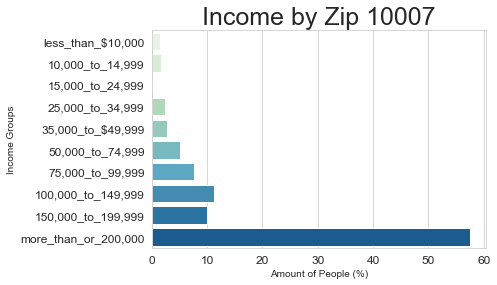

In [48]:
plot_income_by_zip(df, 10007)

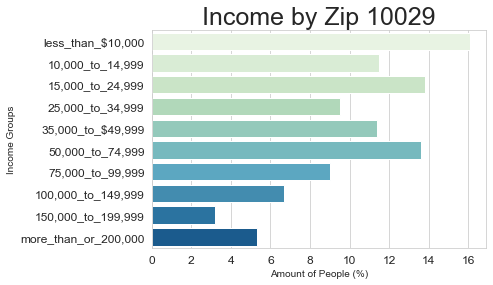

In [49]:
plot_income_by_zip(df, 10029)

**Observation:**  
There are 10 income group categories for each zip code. Some zip codes have higher concentration of low income groups and others have stronger concentration of high income groups. 

## Yelp_Income

In [50]:
# Reading yelp.csv file
yelp_df = pd.read_csv('../data/yelp.csv')
yelp_df.head(3)

,zipcode,price_$,price_$$,price_$$$,price_$$$$,median_income
0,10001,17,59,9,1,88526.0
1,10002,45,103,14,1,35859.0
2,10003,32,135,27,7,112131.0


In [51]:
# Setting new column names for future plotting
new_columns_dict = {
    'zipcode':      'zip_code',
    'price_$':      '1$',
    'price_$$':     '2$',
    'price_$$$':    '3$',
    'price_$$$$':   '4$'}

# Replacing old column names with new
yelp_df.rename(columns = new_columns_dict, inplace=True)
yelp_df.head(3)

,zip_code,1$,2$,3$,4$,median_income
0,10001,17,59,9,1,88526.0
1,10002,45,103,14,1,35859.0
2,10003,32,135,27,7,112131.0


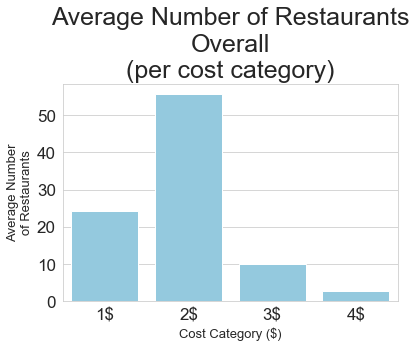

In [52]:
# Finding average amount of all restarants in each $-group
yelp_mean = yelp_df.drop(['zip_code','median_income'], axis=1).mean()

sns.set_style("whitegrid")

# Plotting average amount of all restarants in each $-group
sns.barplot(yelp_mean.index, 
            yelp_mean.values,
           color="skyblue");

# Setting the title to size 35
plt.title ('Average Number of Restaurants\nOverall\n(per cost category)', 
           size=25);
plt.ylabel('Average Number\nof Restaurants', size = 13);
plt.xlabel('Cost Category ($)', size = 13);
# setting size of yticks and xticks to 20
plt.yticks(size = 17);
plt.xticks(size = 17);


**Observation:**
2$ cost category restaurants have the highest avarage number for all zip codes in New York City. We decide to see if the destribution of restarants shift with change in income.

In [53]:
# Find the cut off point beween high and low income, as median of the whole income group
cut_off_point = yelp_df['median_income'].median()
cut_off_point

107178.0

In [54]:
# Slicing yelp data set into 2 sets: high and low income
# zip_code 10020 has no income, that is why there is only 20 high income and 20 low income observations
# High Income
yelp_df_high = yelp_df[yelp_df['median_income'] >= cut_off_point].sort_values('zip_code')
yelp_df_high.shape

(20, 6)

In [55]:
# Low Income
yelp_df_low = yelp_df[yelp_df['median_income'] < cut_off_point].sort_values('zip_code')
yelp_df_low.shape

(20, 6)

In [56]:
# High Income preview
yelp_df_high.head()

,zip_code,1$,2$,3$,4$,median_income
2,10003,32,135,27,7,112131.0
3,10004,19,39,5,2,157645.0
4,10005,15,21,2,1,173333.0
5,10006,7,20,2,0,176250.0
6,10007,23,42,4,3,246813.0


In [57]:
# Getting mean of each restaurant cost estimates overall
yelp_df.drop(['zip_code','median_income'], axis=1).mean()

1$    24.268293
2$    55.634146
3$    10.024390
4$     2.853659
dtype: float64

In [58]:
# Getting mean of each restaurant cost estimates for all neighborhoods with high income
yelp_df_high.drop(['zip_code','median_income'], axis=1).mean()

1$    13.55
2$    56.95
3$    13.80
4$     3.50
dtype: float64

In [59]:
# Getting mean of each restaurant cost estimates for all neighborhoods with low income
yelp_df_low.drop(['zip_code','median_income'], axis=1).mean()

1$    35.60
2$    56.50
3$     6.45
4$     2.30
dtype: float64

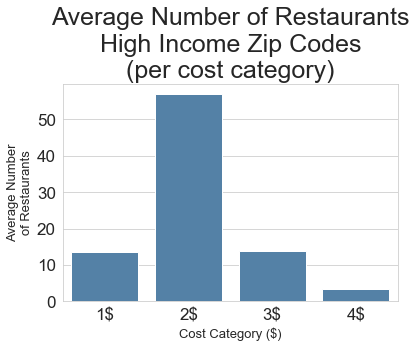

In [60]:
# Finding average amount of all restarants in each $-group for zipcodes 
# with income over cut off point($107K)
yelp_mean = yelp_df_high.drop(['zip_code','median_income'], axis=1).mean()

sns.set_style("whitegrid")

# Plotting average amount of all restarants in each $-group
sns.barplot(yelp_mean.index, 
            yelp_mean.values,
           color="steelblue");

# Setting the title to size 35
plt.title ('Average Number of Restaurants\nHigh Income Zip Codes\n(per cost category)', 
           size=25);
plt.ylabel('Average Number\nof Restaurants', size = 13);
plt.xlabel('Cost Category ($)', size = 13);
# setting size of yticks and xticks to 20
plt.yticks(size = 17);
plt.xticks(size = 17);

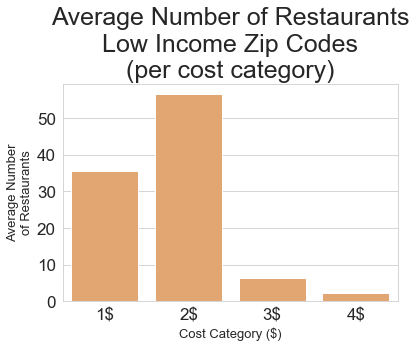

In [61]:
# Finding average amount of all restarants in each $-group for zipcodes 
# with income under cut off point($107K)
yelp_mean = yelp_df_low.drop(['zip_code','median_income'], axis=1).mean()

sns.set_style("whitegrid")

# Plotting average amount of all restarants in each $-group
sns.barplot(yelp_mean.index, 
            yelp_mean.values,
           color="sandybrown");

# Setting the title to size 35
plt.title ('Average Number of Restaurants\nLow Income Zip Codes\n(per cost category)', 
           size=25);
plt.ylabel('Average Number\nof Restaurants', size = 13);
plt.xlabel('Cost Category ($)', size = 13);
# setting size of yticks and xticks to 20
plt.yticks(size = 17);
plt.xticks(size = 17);

### Visualizations by Zip code (highest and lowest median income)

In [62]:
# Finding zip codes with highest median income
yelp_df.sort_values('median_income', ascending = False).head()

,zip_code,1$,2$,3$,4$,median_income
6,10007,23,42,4,3,246813.0
5,10006,7,20,2,0,176250.0
4,10005,15,21,2,1,173333.0
40,10280,2,5,0,0,169844.0
3,10004,19,39,5,2,157645.0


In [63]:
# Finding zip codes with lowest median income
yelp_df.sort_values('median_income', ascending = True).head()

,zip_code,1$,2$,3$,4$,median_income
32,10035,23,18,0,0,30081.0
26,10029,77,66,2,1,34016.0
1,10002,45,103,14,1,35859.0
27,10030,23,18,1,0,37232.0
36,10039,17,8,0,0,39653.0


In [64]:
# function plots barchart with business count per zip code
# requiered parameters: dataset and business yelp group
def plot_business_count_per_zip(df, variable):
    plt.figure(figsize=(4,10));

    labels = np.array(df['zip_code']);
    values = np.array(df[variable]); 
    clrs = ['steelblue' if (x == 10004 or x==10005 or x==10007)
            else 'sandybrown' if (x == 10002 or x == 10029 or x == 10035) 
            else 'lightgray' for x in labels];

    sns.barplot(y=labels, # restaraunt count per zip code
                x=values, # zip codes
                palette=clrs, # using colors based on condition
               orient = 'h'); # horizontal

    # setting title to size 25
    plt.title (f'Number of {variable} Restaurants\nby Zip Code', size=25);
    plt.ylabel('Zip Code', size = 15);
    plt.xlabel('Restaurant Count', size = 15);
    # setting size of yticks and xticks to 13
    plt.yticks(size = 13);
    plt.xticks(size = 13);

    # creating a cumstom legend
    name_to_color = {
        'Highest Income':   'steelblue',
        'Lowest Income':   'sandybrown',
    }

    patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in name_to_color.items()]
    plt.legend(handles=patches, loc='lower right');

#### Group 1 by Income

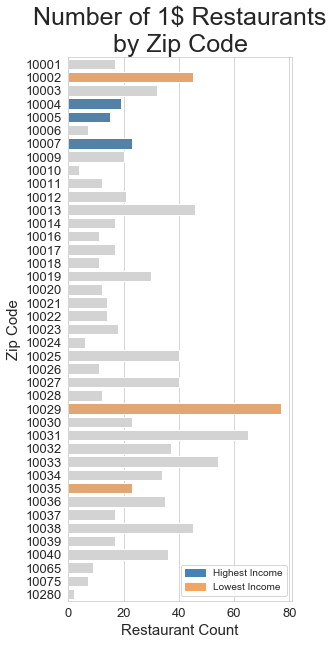

In [65]:
plot_business_count_per_zip(yelp_df, '1$')

#### Group 2 by Income

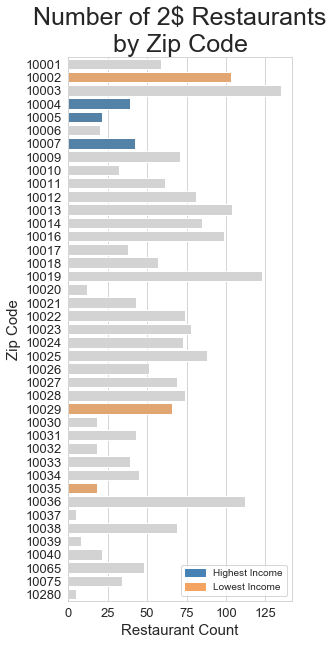

In [66]:
plot_business_count_per_zip(yelp_df, '2$')

#### Group 3 by Income

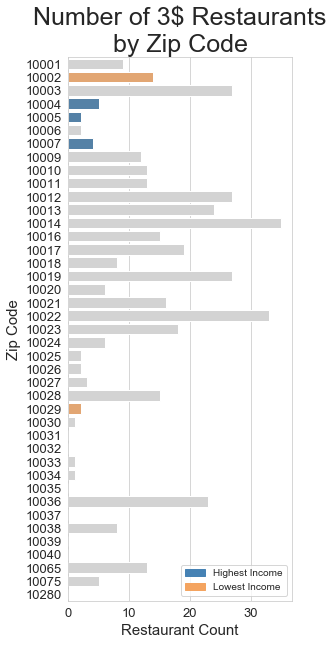

In [67]:
plot_business_count_per_zip(yelp_df, '3$')

#### Group 4  by Income

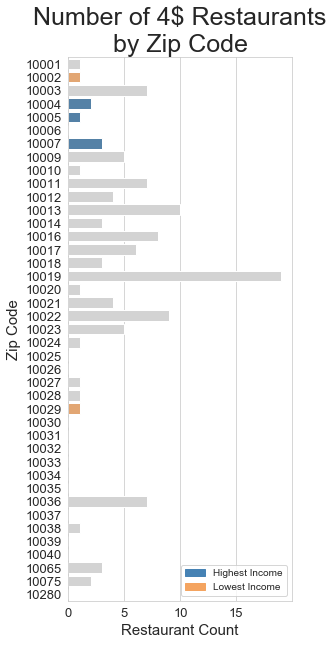

In [68]:
plot_business_count_per_zip(yelp_df, '4$')

### Visualizations: Zip codes with highest number of restaurants: 10012, 10014, 10019, 10022

There are four zip codes with highest amount of restarants in $$$ cost restaurant estimate group. We decided to see if this trend applies to other restaurant cost gategories and to see what type of income is prevelent in these areas.

In [69]:
# function plots barchart with business with highest count in 
# 3$ yelp group per zip code 
# requiered parameters: dataset and business yelp group
def plot_business_most_count_per_zip(df, variable):
    plt.figure(figsize=(4,10));

    labels = np.array(df['zip_code']);
    values = np.array(df[variable]); 
    clrs = ['mediumseagreen' if (x == 10012 or x==10014 or x==10019 or x==10022) 
            else 'lightgray' for x in labels];

    sns.barplot(y=labels, 
                x=values, 
                palette=clrs,
               orient = 'h');

    plt.title (f'Number of {variable} Restaurants\nby Zip Code', size=25);
    plt.ylabel('Zip Code', size = 15);
    plt.xlabel('Restaurant Count', size = 15);
    # setting size of yticks and xticks to 20
    plt.yticks(size = 13);
    plt.xticks(size = 13);

    # creating a cumstom legend
    # credit to the source: https://stackoverflow.com/questions/32261619/how-to-add-legend-on-seaborn-facetgrid-bar-plot/55953685
    name_to_color = {
        'Highest 3$ Count':   'mediumseagreen',
        'Lowest 3$ Count':   'lightgray',
    }

    patches = [matplotlib.patches.Patch(color=v, label=k) for k,v in name_to_color.items()]
    plt.legend(handles=patches, loc='lower right');

#### Group 1 by Count

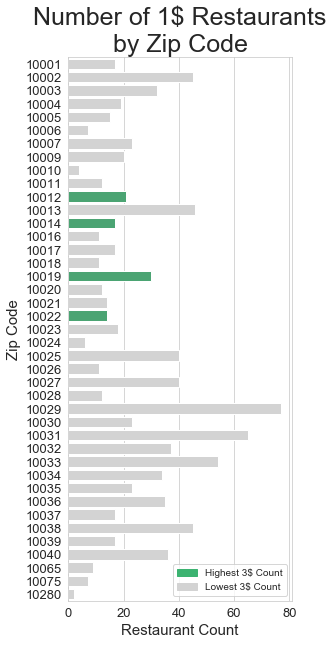

In [70]:
plot_business_most_count_per_zip(yelp_df, '1$')

#### Group 2 by Count

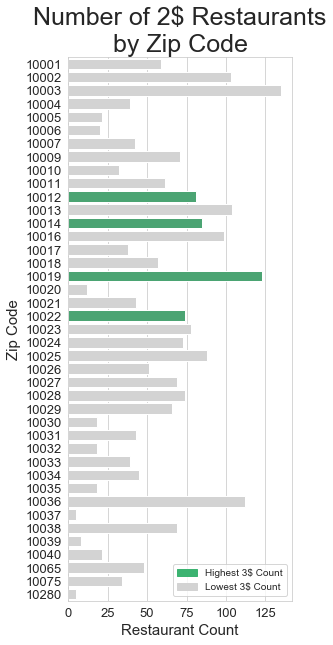

In [71]:
plot_business_most_count_per_zip(yelp_df, '2$')

#### Group 3 by Count

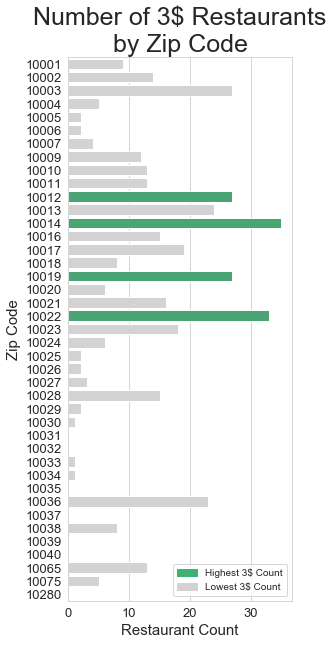

In [72]:
plot_business_most_count_per_zip(yelp_df, '3$')

#### Group 4 by Count

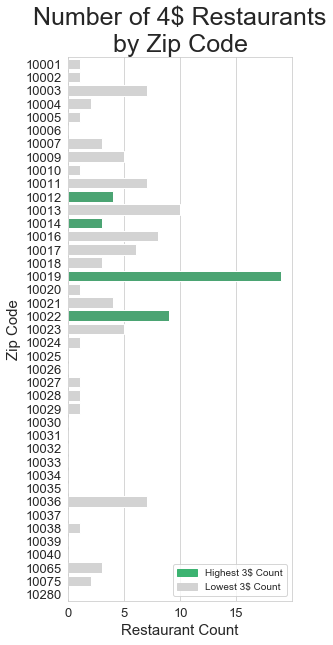

In [73]:
plot_business_most_count_per_zip(yelp_df, '4$')

Plotting the income groups for each of these four zip codes: 10012, 10014, 10019, 10022

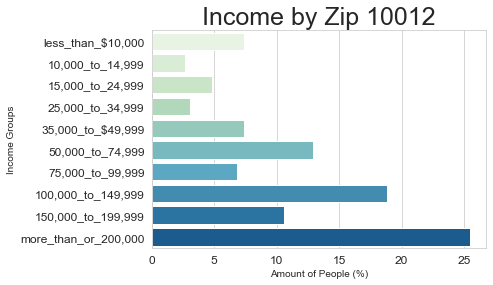

In [74]:
plot_income_by_zip(df, 10012)

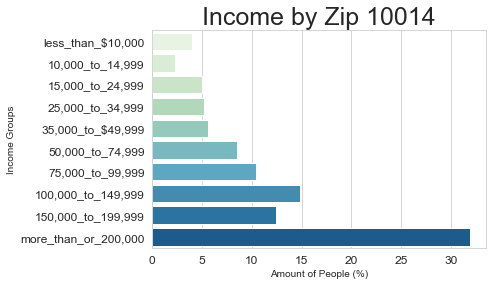

In [75]:
plot_income_by_zip(df, 10014)

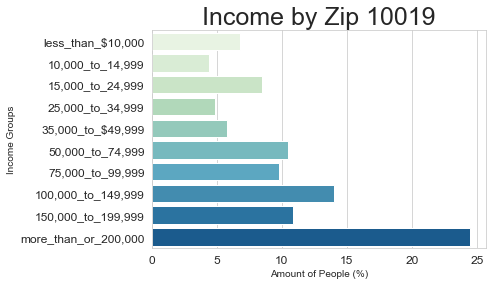

In [76]:
plot_income_by_zip(df, 10019)

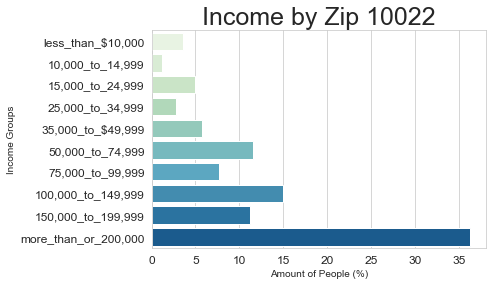

In [77]:
plot_income_by_zip(df, 10022)

**Observation:**
It appears that zip codes 10012, 10014, 10019, 10022 are the areas with the highest concentration of restaurants of most cost categories and these neighborhoods have mostly high income groups. 

---

## GeoMaps for Manhattan

It is easier to see the tred and correlation through map visualisations, so we decided to apply our findings into the whole map of New York City.

In [78]:
# importing libraries
# pip install geopandas
# conda install descartes
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
%matplotlib inline
import geopandas as gpd
from shapely.geometry import Polygon, Point
import matplotlib.pyplot as plt
from descartes.patch import PolygonPatch

# make_axes_locatable is for seperating plot and legend
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [79]:
# reading the file of all coordinates for City of New York, for future map plots
# source for zip code new york city boundaries:
# https://data.cityofnewyork.us/widgets/i8iw-xf4u
nyc = gpd.read_file('../data/zip/ZIP_CODE_040114.shp')
nyc.head(2)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,11436,0,Jamaica,18681.0,2.269930e+07,NY,Queens,36,081,http://www.usps.com/,0.0,0.0,"POLYGON ((1038098.252 188138.380, 1038141.936 ..."
1,11213,0,Brooklyn,62426.0,2.963100e+07,NY,Kings,36,047,http://www.usps.com/,0.0,0.0,"POLYGON ((1001613.713 186926.440, 1002314.243 ..."


In [80]:
# checking the columns of the dataframe
nyc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 13 columns):
ZIPCODE       263 non-null object
BLDGZIP       263 non-null object
PO_NAME       263 non-null object
POPULATION    263 non-null float64
AREA          263 non-null float64
STATE         263 non-null object
COUNTY        263 non-null object
ST_FIPS       263 non-null object
CTY_FIPS      263 non-null object
URL           263 non-null object
SHAPE_AREA    263 non-null float64
SHAPE_LEN     263 non-null float64
geometry      263 non-null geometry
dtypes: float64(4), geometry(1), object(8)
memory usage: 26.8+ KB


In [81]:
# Reading yelp.csv file
yelp = pd.read_csv('../data/yelp.csv')
yelp.head(3)

,zipcode,price_$,price_$$,price_$$$,price_$$$$,median_income
0,10001,17,59,9,1,88526.0
1,10002,45,103,14,1,35859.0
2,10003,32,135,27,7,112131.0


In [82]:
# Setting new column names for future plotting
new_columns_dict = {
    'price_$':      '1$',
    'price_$$':     '2$',
    'price_$$$':    '3$',
    'price_$$$$':   '4$'}

# Replacing old column names with new
yelp.rename(columns = new_columns_dict, inplace=True)

In [83]:
# sorting zip codes of New York city by median income
yelp.sort_values('median_income', ascending=False).head()

,zipcode,1$,2$,3$,4$,median_income
6,10007,23,42,4,3,246813.0
5,10006,7,20,2,0,176250.0
4,10005,15,21,2,1,173333.0
40,10280,2,5,0,0,169844.0
3,10004,19,39,5,2,157645.0


In [84]:
# checking the number of zip codes that we woring with
yelp.shape

(41, 6)

In [85]:
# Converting zip_code from census_income.csv file to
# get a list of only those zip codes that we areworking with
yelp['zipcode'] = yelp['zipcode'].astype(str)
manhattan_zip_code_list = yelp['zipcode'].tolist()

# getting only manhattan for plotting
manhattan = nyc.loc[nyc['ZIPCODE'].isin(manhattan_zip_code_list)]

# checking the size of the mahnattan df
manhattan.shape

(45, 13)

In [86]:
# since zip code 10004 and appears more than once, 
# we deleting those rows [109 , 113, 114]
manhattan = manhattan.drop([109, 113, 114])

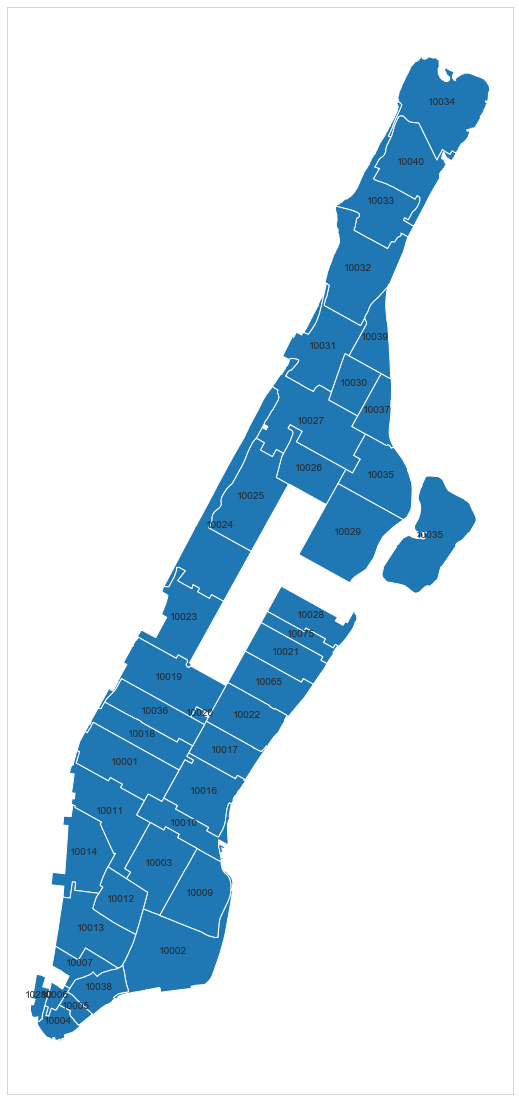

In [87]:
# source for geomap plotting:
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac

# Setting a template for geomap of Manhattan only (by zip codes)
ax = manhattan.plot(figsize=(30,20));
manhattan.apply(lambda x: ax.annotate(s=x.ZIPCODE, 
                               xy=x.geometry.centroid.coords[0], 
                               ha='center'), axis=1);
#removing ticks
plt.yticks([],[]);
plt.xticks([],[]);

In [88]:
# Merge two dataframes: yelp and income with manhattan map (by zip code)
merged_df = pd.merge(manhattan, yelp, left_on='ZIPCODE', right_on='zipcode')
# checking the merge
merged_df.head(2)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry,zipcode,1$,2$,3$,4$,median_income
0,10034,0,New York,39149.0,2.450389e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((1006203.169 257345.657, 1006214.666 ...",10034,34,45,1,0,54716.0
1,10033,0,New York,54284.0,1.615605e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((1003020.865 256049.162, 1003096.046 ...",10033,54,39,1,0,58614.0


In [89]:
# credit ot this source:
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac
# function map_plot will plot a geomap of New York City and color each zip code
# based of a value of specific variable. 
# Orifinal datbase with coordinates, variable name, Graph title, legend tile 
# are required paramenters. Color can be changed if needed.
def map_plot(df, variable, graph_title, legend_title, color = 'Greens'):
    
    # set the range for the choropleth
    vmin, vmax = 120, 220
    # create figure and axes for Matplotlib
    fig, ax = plt.subplots(1, 1,  figsize=(20, 12))
    ## divider and cax separate legend from main plot
    divider = make_axes_locatable(ax)
    ## cax controls legend only
    cax = divider.append_axes('right', size = '5%', pad = 0.1)
    df.plot(column=variable, cmap=color,
            linewidth=0.8,
            ax=ax,
            edgecolor='0.8',
            legend = True,
            cax = cax) ## add legend to plot
    
    ## plt controls the legend
    plt.tick_params(labelsize = 15)
    plt.title(legend_title, loc = 'left', size = 15)
    
    ## ax controls the plot
    ax.set_yticks([],[]);
    ax.set_xticks([],[]);
    ax.set_title(graph_title, size=30);
    
    # Creating annoations (zip codes number) to apply in our map
    df.apply(lambda x: ax.annotate(s=x.ZIPCODE, 
                                   xy=x.geometry.centroid.coords[0], 
                                   ha='center'), axis=1);
    plt.tight_layout()

### Map by Income

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\matplotlib\colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


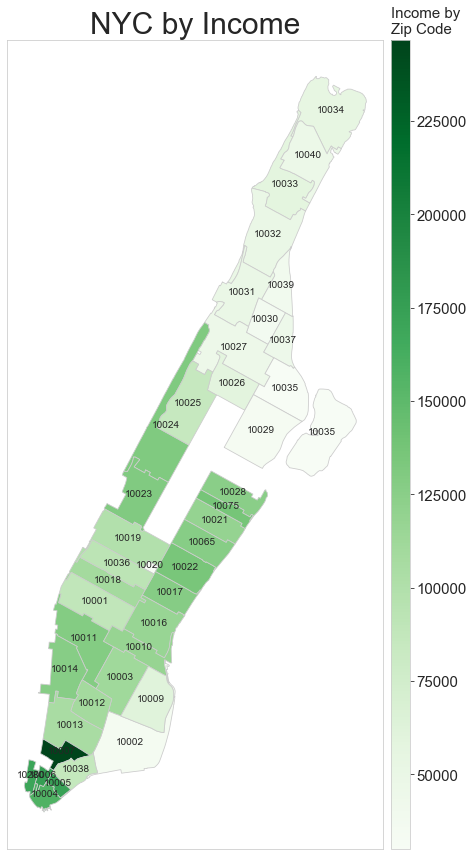

In [90]:
# plotting NYC map by Median Income
map_plot(merged_df, 'median_income', 'NYC by Income', "Income by\nZip Code")

### Map by 1-dollar Restaurants

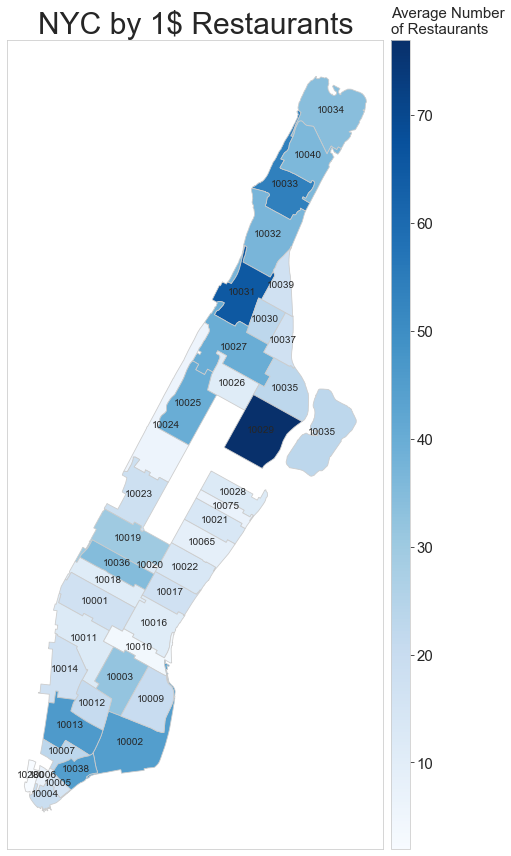

In [91]:
# plotting NYC map by 1$ group
map_plot(merged_df, '1$', 'NYC by 1$ Restaurants', "Average Number\nof Restaurants", 'Blues')

**Observation:**  
Direct correlation between personal median income and restaurant cost was noted.
Specifically, lower income zip codes have the highest number of restaurants with the lowest cost ($).


### Map by 2-dollar Restaurants

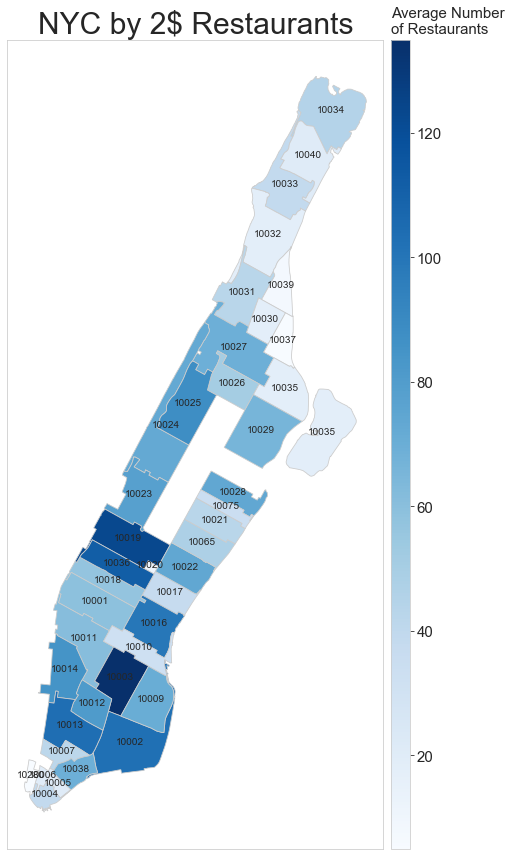

In [92]:
# plotting NYC map by 2$ group
map_plot(merged_df, '2$', 'NYC by 2$ Restaurants', "Average Number\nof Restaurants", 'Blues')

**Observation**:  
Restaurants in a ($$) cost category seem to be evenly spread in the highest income zip codes (with a few notable exceptions). Additionally, restaurants in low income zip codes appear to be thinning out.


### Map by 3-dollar Restaurants

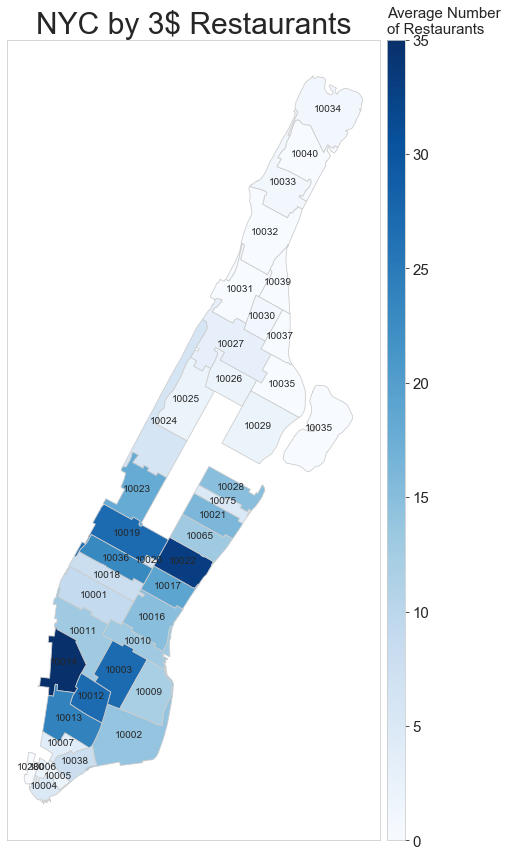

In [93]:
# plotting NYC map by 3$ group
map_plot(merged_df, '3$', 'NYC by 3$ Restaurants', "Average Number\nof Restaurants", 'Blues')

**Observation:**  
Restaurants with ($$$) costs have all but abandoned low income zip codes, while distribution of these restaurants in high income zip codes is concentrated in select few.  


### Map by 4-dollar Restaurants

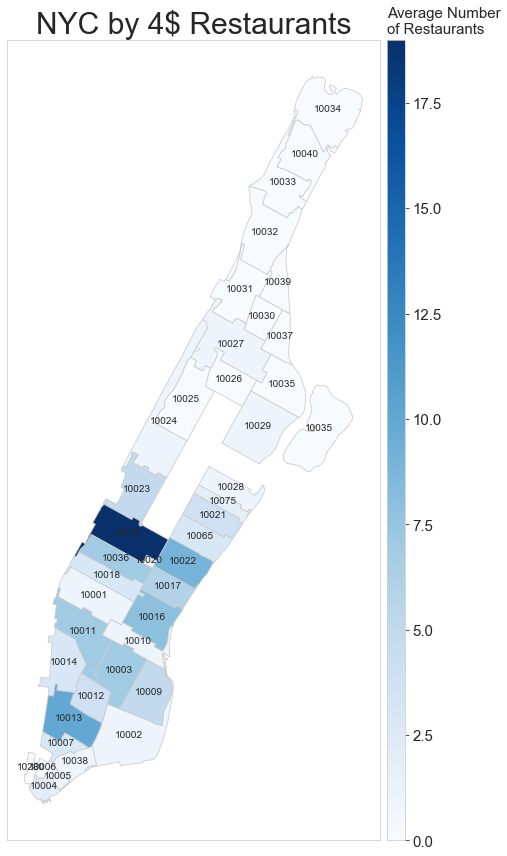

In [94]:
# plotting NYC map by 4$ group
map_plot(merged_df, '4$', 'NYC by 4$ Restaurants', "Average Number\nof Restaurants", 'Blues')

**Observation:**  
Highest income zip codes boast the greatest number of restaurants with top cost (4$). Presence of this type of restaurants in low income zip codes is nil.  


# Data Cleaning

### Read in Data for Cleaning
Here we load in our webscraped yelp data to begin the cleaning process. We take a glance at the dataset looks like and how large it is. 

In [95]:
# Read in data
yelp = pd.read_csv("../data/manhattan.csv")

In [96]:
# Check out first five rows
yelp.head()

,id,alias,name,image_url,is_closed,url,review_count,categories,rating,coordinates,transactions,price,location,phone,display_phone,distance
0,H4jJ7XB3CetIr1pg56CczQ,levain-bakery-new-york,Levain Bakery,https://s3-media2.fl.yelpcdn.com/bphoto/zgjSt_...,False,https://www.yelp.com/biz/levain-bakery-new-yor...,7932,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",4.5,"{'latitude': 40.7799404643263, 'longitude': -7...",[],$$,"{'address1': '167 W 74th St', 'address2': '', ...",1.917464e+10,(917) 464-3769,2198.507677
1,xEnNFXtMLDF5kZDxfaCJgA,the-halal-guys-new-york-2,The Halal Guys,https://s3-media1.fl.yelpcdn.com/bphoto/24lb-V...,False,https://www.yelp.com/biz/the-halal-guys-new-yo...,9297,"[{'alias': 'foodstands', 'title': 'Food Stands...",4.0,"{'latitude': 40.761854, 'longitude': -73.979363}",[],$,"{'address1': 'W 53rd St 6th Ave', 'address2': ...",NaN,NaN,196.205599
2,44SY464xDHbvOcjDzRbKkQ,ippudo-ny-new-york-7,Ippudo NY,https://s3-media1.fl.yelpcdn.com/bphoto/zF3Egq...,False,https://www.yelp.com/biz/ippudo-ny-new-york-7?...,9949,"[{'alias': 'ramen', 'title': 'Ramen'}]",4.0,"{'latitude': 40.73092, 'longitude': -73.99015}","['delivery', 'pickup']",$$,"{'address1': '65 4th Ave', 'address2': '', 'ad...",NaN,NaN,3402.912662
3,V7lXZKBDzScDeGB8JmnzSA,katzs-delicatessen-new-york,Katz's Delicatessen,https://s3-media1.fl.yelpcdn.com/bphoto/B6xNx7...,False,https://www.yelp.com/biz/katzs-delicatessen-ne...,12109,"[{'alias': 'delis', 'title': 'Delis'}, {'alias...",4.0,"{'latitude': 40.722237, 'longitude': -73.98743}","['delivery', 'pickup']",$$,"{'address1': '205 E Houston St', 'address2': '...",1.212254e+10,(212) 254-2246,4289.433760
4,jVncyqXwlx_D9f2xZn05tg,the-metropolitan-museum-of-art-new-york-3,The Metropolitan Museum of Art,https://s3-media2.fl.yelpcdn.com/bphoto/lHEKQR...,False,https://www.yelp.com/biz/the-metropolitan-muse...,2838,"[{'alias': 'artmuseums', 'title': 'Art Museums'}]",4.5,"{'latitude': 40.779449, 'longitude': -73.963245}",[],NaN,"{'address1': '1000 5th Ave', 'address2': '', '...",1.212536e+10,(212) 535-7710,2494.912991


In [97]:
# Look at the number of rows and columns in dataframe
yelp.shape

(4807, 16)

### Drop Unnecessary Columns
There are many columns that arent't going to be useful to our modeling such as a restaurant's coordinates or phone number so we are going to drop these columns from our dataset.

In [98]:
# Get all column names in the dataframe
yelp.columns

Index(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count',
       'categories', 'rating', 'coordinates', 'transactions', 'price',
       'location', 'phone', 'display_phone', 'distance'],
      dtype='object')

In [99]:
# Drop columns that aren't necessary
yelp = yelp.drop(columns = ['id', 'alias', 'image_url', 'is_closed', 'url', 'coordinates', 
                            'transactions', 'phone', 'display_phone', 'distance'])

In [100]:
# Previewing the adjusted dataframe
yelp.head()

,name,review_count,categories,rating,price,location
0,Levain Bakery,7932,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",4.5,$$,"{'address1': '167 W 74th St', 'address2': '', ..."
1,The Halal Guys,9297,"[{'alias': 'foodstands', 'title': 'Food Stands...",4.0,$,"{'address1': 'W 53rd St 6th Ave', 'address2': ..."
2,Ippudo NY,9949,"[{'alias': 'ramen', 'title': 'Ramen'}]",4.0,$$,"{'address1': '65 4th Ave', 'address2': '', 'ad..."
3,Katz's Delicatessen,12109,"[{'alias': 'delis', 'title': 'Delis'}, {'alias...",4.0,$$,"{'address1': '205 E Houston St', 'address2': '..."
4,The Metropolitan Museum of Art,2838,"[{'alias': 'artmuseums', 'title': 'Art Museums'}]",4.5,NaN,"{'address1': '1000 5th Ave', 'address2': '', '..."


### Drop Null Values in Price Column
After dropping unneeded columns, we are going to look for any null values and only drop the ones that don't have a value for the price column as our problem statement relies on this value for our model. 

In [101]:
# Find count of null values in each column
yelp.isna().sum()

name              0
review_count      0
categories        0
rating            0
price           506
location          0
dtype: int64

In [102]:
# Drop all null values since they are only present in the price column
yelp = yelp.dropna()

In [103]:
# Reset our index to be chronological again
yelp = yelp.reset_index(drop = True)

### Isolate Zip Code in Location Column
Here we are going to extract the zip code of each restaurant as we want to fine tune the dataset for concatenation with the median income dataset later. In addition, the full address, isn't completely useful to us. 

In [104]:
# Read the value as a dictionary instead of a string
yelp['location'] = yelp['location'].apply(ast.literal_eval)

In [105]:
# Extract zipcode and append to an empty list
zipcodes = []
for x in yelp['location']:
    zipcodes.append(x['zip_code'])

In [106]:
# Create new column in dataframe with just the zip codes
yelp['zipcode'] = zipcodes

In [107]:
# Preview dataframe
yelp.head()

,name,review_count,categories,rating,price,location,zipcode
0,Levain Bakery,7932,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",4.5,$$,"{'address1': '167 W 74th St', 'address2': '', ...",10023
1,The Halal Guys,9297,"[{'alias': 'foodstands', 'title': 'Food Stands...",4.0,$,"{'address1': 'W 53rd St 6th Ave', 'address2': ...",10019
2,Ippudo NY,9949,"[{'alias': 'ramen', 'title': 'Ramen'}]",4.0,$$,"{'address1': '65 4th Ave', 'address2': '', 'ad...",10003
3,Katz's Delicatessen,12109,"[{'alias': 'delis', 'title': 'Delis'}, {'alias...",4.0,$$,"{'address1': '205 E Houston St', 'address2': '...",10003
4,Bibble & Sip,4747,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.5,$,"{'address1': '253 W 51st St', 'address2': '', ...",10019


### Isolate Alias in Categories Column
Similarly to what we did with the zip codes, we are going to extract the aliases for each restuarant for possible future feature classification.

In [108]:
# Read the value as a list of dictionaries instead of a string
yelp['categories'] = yelp['categories'].apply(ast.literal_eval)

In [109]:
# Isolate aliases and append into an empty list
names = []
for rest in yelp['categories']:
    output = ''
    for alias in rest:
        output += alias['alias']
        output += ','
    output = output[:-1]
    names.append(output)

In [110]:
# Create a new column in dataframe with aliases for each restuarant
yelp['type'] = names

In [111]:
# Preview dataframe
yelp.head()

,name,review_count,categories,rating,price,location,zipcode,type
0,Levain Bakery,7932,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",4.5,$$,"{'address1': '167 W 74th St', 'address2': '', ...",10023,bakeries
1,The Halal Guys,9297,"[{'alias': 'foodstands', 'title': 'Food Stands...",4.0,$,"{'address1': 'W 53rd St 6th Ave', 'address2': ...",10019,"foodstands,mideastern,halal"
2,Ippudo NY,9949,"[{'alias': 'ramen', 'title': 'Ramen'}]",4.0,$$,"{'address1': '65 4th Ave', 'address2': '', 'ad...",10003,ramen
3,Katz's Delicatessen,12109,"[{'alias': 'delis', 'title': 'Delis'}, {'alias...",4.0,$$,"{'address1': '205 E Houston St', 'address2': '...",10003,"delis,sandwiches,catering"
4,Bibble & Sip,4747,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.5,$,"{'address1': '253 W 51st St', 'address2': '', ...",10019,"coffee,bakeries"


In [112]:
# Dummy types of aliases
alias_types = yelp['type'].str.get_dummies(sep = ',')

### Create Master Dataframe
Here we combine our dummied alias types to the original yelp dataframe we were working with intially. 

In [113]:
# Merge yelp dataframe with dummied alias columns
combined_df = yelp.merge(alias_types, left_index = True, right_index = True)

In [114]:
# Preview master dataframe
combined_df.head()

,name,review_count,categories,rating,price,location,zipcode,type,acaibowls,afghani,...,uzbek,vegan,vegetarian,venezuelan,venues,vietnamese,waffles,whiskeybars,wine_bars,wraps
0,Levain Bakery,7932,"[{'alias': 'bakeries', 'title': 'Bakeries'}]",4.5,$$,"{'address1': '167 W 74th St', 'address2': '', ...",10023,bakeries,0,0,...,0,0,0,0,0,0,0,0,0,0
1,The Halal Guys,9297,"[{'alias': 'foodstands', 'title': 'Food Stands...",4.0,$,"{'address1': 'W 53rd St 6th Ave', 'address2': ...",10019,"foodstands,mideastern,halal",0,0,...,0,0,0,0,0,0,0,0,0,0
2,Ippudo NY,9949,"[{'alias': 'ramen', 'title': 'Ramen'}]",4.0,$$,"{'address1': '65 4th Ave', 'address2': '', 'ad...",10003,ramen,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Katz's Delicatessen,12109,"[{'alias': 'delis', 'title': 'Delis'}, {'alias...",4.0,$$,"{'address1': '205 E Houston St', 'address2': '...",10003,"delis,sandwiches,catering",0,0,...,0,0,0,0,0,0,0,0,0,0
4,Bibble & Sip,4747,"[{'alias': 'coffee', 'title': 'Coffee & Tea'},...",4.5,$,"{'address1': '253 W 51st St', 'address2': '', ...",10019,"coffee,bakeries",0,0,...,0,0,0,0,0,0,0,0,0,0


In [115]:
# See new number of rows and columns
combined_df.shape

(4301, 247)

### Filtering Non Restaurants
Here we begin to manually filter through certain aliases as our problem statement focuses on restaurants and some locations that simply sell food made it into our dataset. Therefore, we manually look at standout aliases and remove those rows such as bowling alleys. 

In [116]:
# Dropping non-restuarants
combined_df = combined_df.drop(index = [1274, 1874, 640, 1418, 1515, 2245, 3271, 4144, 1585, 1313, 2484, 3492, 3521, 
                                        3085, 3216, 3888, 864, 1725, 1731, 4160, 4291, 1003, 1767, 3112, 4191, 3040, 
                                        719, 2697, 3609, 3712, 3681, 3737, 24, 1072, 1130, 1163, 2126, 2429, 2749, 
                                        2913, 2975, 3044, 3611, 3759, 3895, 3985, 4132, 4263, 1530, 1435, 3172, 463, 
                                        993, 2024, 2732, 3904, 4012, 1076, 1238, 1270, 1725, 1767, 2651, 3396, 1143, 
                                        1585, 1655, 2346, 2510, 3014, 253, 4290, 4251, 911, 900, 948, 1131, 1202, 
                                        1216, 2651, 3578, 2996, 3366, 1520, 957, 3221, 2211, 1103, 2534, 3262, 
                                        3814, 2591])

In [117]:
# Resetting the index to be chronological
combined_df = combined_df.reset_index(drop = True)

### Price Dummy Columns
Here we want to dummy the price column in order to get the count of the price ranges for each zip code. Then we can group by zip code and focus our yelp data. 

In [118]:
# Dummy price column
combined_df = pd.get_dummies(data = combined_df, columns = ['price'])

In [119]:
# View only the zipcode and price columns
combined_df[['zipcode','price_$', 'price_$$', 'price_$$$', 'price_$$$$']]

,zipcode,price_$,price_$$,price_$$$,price_$$$$
0,10023,0,1,0,0
1,10019,1,0,0,0
2,10003,0,1,0,0
3,10003,0,1,0,0
4,10019,1,0,0,0
...,...,...,...,...,...
4208,10034,1,0,0,0
4209,10040,1,0,0,0
4210,10034,1,0,0,0
4211,10034,1,0,0,0


In [120]:
# Save count of each price type sorted by zip code as new variable
grouped_df = combined_df[['zipcode','price_$', 'price_$$', 'price_$$$', 'price_$$$$']].groupby('zipcode').sum().reset_index()

In [121]:
# Preview new variable/dataframe
grouped_df.head()

,zipcode,price_$,price_$$,price_$$$,price_$$$$
0,,5,1,0,0
1,07010,0,1,0,0
2,07020,2,8,3,0
3,07024,2,9,1,0
4,07047,0,2,0,0


### Imputing Data
Here we fill in missing zipcode values that we may be able to determine from a Google search or we drop additional rows that we cannot find a value to impute for. 

In [122]:
# Locate value for missing zip codes
grouped_df.loc[0,'zipcode']

''

In [123]:
# Pull all rows with an empty zip code
combined_df[combined_df['zipcode'] == '']

,name,review_count,categories,rating,location,zipcode,type,acaibowls,afghani,african,...,venues,vietnamese,waffles,whiskeybars,wine_bars,wraps,price_$,price_$$,price_$$$,price_$$$$
1817,Galbi Q,33,"[{'alias': 'streetvendors', 'title': 'Street V...",4.5,"{'address1': 'W 52nd St', 'address2': '', 'add...",,"streetvendors,gourmet,korean",0,0,0,...,0,0,0,0,0,0,1,0,0,0
1897,Evantina's Coffee Cart,1,"[{'alias': 'coffee', 'title': 'Coffee & Tea'}]",4.0,"{'address1': '50TH St 6th And 7th Ave', 'addre...",,coffee,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3019,Eddie's Pizza Truck,93,"[{'alias': 'foodstands', 'title': 'Food Stands...",3.0,"{'address1': '', 'address2': None, 'address3':...",,"foodstands,pizza",0,0,0,...,0,0,0,0,0,0,1,0,0,0
3042,Halal Food,20,"[{'alias': 'foodstands', 'title': 'Food Stands...",4.0,"{'address1': '', 'address2': '', 'address3': '...",,"foodstands,halal",0,0,0,...,0,0,0,0,0,0,1,0,0,0
3059,Deli & Dogz,12,"[{'alias': 'foodtrucks', 'title': 'Food Trucks...",4.0,"{'address1': '', 'address2': '', 'address3': '...",,"foodtrucks,kosher,sandwiches",0,0,0,...,0,0,0,0,0,0,0,1,0,0
4038,La Suegra De Dyckman,7,"[{'alias': 'streetvendors', 'title': 'Street V...",4.5,"{'address1': '', 'address2': '', 'address3': '...",,"streetvendors,mexican,foodstands",0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [124]:
# Impute found zip code
combined_df['zipcode'][1817] = '10019'

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [125]:
# Impute found zip code
combined_df['zipcode'][1897] = '10020'

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [126]:
# Drop rows where a zip code could not be imputed
combined_df = combined_df.drop(index = [3019, 3042, 3059, 4038])

In [127]:
# Reset index to be chronological 
combined_df = combined_df.reset_index(drop = True)

In [128]:
# Resort and group restaurants 
grouped_df = combined_df[['zipcode','price_$', 'price_$$', 'price_$$$', 'price_$$$$']].groupby('zipcode').sum().reset_index()

### Saving Datasets
Here we want to establish our finalized dataframe that contains our restaurant aliases and other data that we intially kept in the beginning. 

In [129]:
# Drop original alias and address columns
restaurants = combined_df.drop(columns = ['categories', 'location'])

In [130]:
# Preview dataframe
restaurants.head()

,name,review_count,rating,zipcode,type,acaibowls,afghani,african,arcades,argentine,...,venues,vietnamese,waffles,whiskeybars,wine_bars,wraps,price_$,price_$$,price_$$$,price_$$$$
0,Levain Bakery,7932,4.5,10023,bakeries,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,The Halal Guys,9297,4.0,10019,"foodstands,mideastern,halal",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Ippudo NY,9949,4.0,10003,ramen,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Katz's Delicatessen,12109,4.0,10003,"delis,sandwiches,catering",0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Bibble & Sip,4747,4.5,10019,"coffee,bakeries",0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


### Merge Yelp Data with Income Data 
Here we want to create the final dataframe that we will work with to conduct our exploratory data analysis and modeling with. We bring in the income dataset and begin to merge it with our yelp data based on zipcode.

In [131]:
# Read in income data
income = pd.read_csv("../data/census_income.csv")

In [132]:
# Rename zip code column
income = income.rename(columns = {'zip_code': 'zipcode'})

In [133]:
# Convert zipcodes from string to integer
zips = []
for zipcode in grouped_df['zipcode']:
    num = int(zipcode)
    zips.append(num)

In [134]:
# Create new zipcode column
grouped_df['zipcode'] = zips

In [135]:
# Merge price data frame with income dataframe
yelp_data = pd.merge(grouped_df, income, how = 'inner', on= 'zipcode')

In [136]:
# Preview resulting dataframe
yelp_data.head()

,zipcode,price_$,price_$$,price_$$$,price_$$$$,median_income
0,10001,17,59,9,1,88526.0
1,10002,45,103,14,1,35859.0
2,10003,32,135,27,7,112131.0
3,10004,19,39,5,2,157645.0
4,10005,15,21,2,1,173333.0


### Exporting Datasets
After cleaning and finalizing our data into two dataframes that we want to work with, we export it for easier reference to other members. 

In [137]:
yelp_data.to_csv('../data/yelp.csv', index = False)
restaurants.to_csv('../data/restaurants.csv', index = False)

# Preprocessing

### Read in Data
Here we read in our cleaned datasets for creating a master dataframe to work with in our model.

In [138]:
# Read in datasets
yelp = pd.read_csv('../data/yelp.csv')
rest = pd.read_csv('../data/restaurants.csv')

### Create a Master DataFrame
Here we feature engineer a new column that averages the yelp cost estimates for each zip code. Then we merge it with the restaurant dataset to have one master dataframe that has all our values at hand.

In [139]:
# Check out the data
yelp.head()

,zipcode,price_$,price_$$,price_$$$,price_$$$$,median_income
0,10001,17,59,9,1,88526.0
1,10002,45,103,14,1,35859.0
2,10003,32,135,27,7,112131.0
3,10004,19,39,5,2,157645.0
4,10005,15,21,2,1,173333.0


In [140]:
# Feature engineering for average yelp cost estimate 
yelp['avg_price'] = (yelp['price_$'] + (2 * yelp['price_$$']) + (3 * yelp['price_$$$']) + (4 * yelp['price_$$$$'])) / (yelp['price_$'] + yelp['price_$$'] + yelp['price_$$$'] + yelp['price_$$$$'])

In [141]:
# Preview to check for new column
yelp.head()

,zipcode,price_$,price_$$,price_$$$,price_$$$$,median_income,avg_price
0,10001,17,59,9,1,88526.0,1.930233
1,10002,45,103,14,1,35859.0,1.822086
2,10003,32,135,27,7,112131.0,2.044776
3,10004,19,39,5,2,157645.0,1.846154
4,10005,15,21,2,1,173333.0,1.717949


In [142]:
# Drop restaurant title and type
columns = rest.drop(columns = ['name', 'type'])

# Create list of column names 
wanted_columns = []
for i in columns:
    wanted_columns.append(i)

# Take the raw count of each alias and groupy by zip code
rest_sums = rest[wanted_columns].groupby('zipcode').sum().reset_index()

# Merge yelp and restaurant datasets 
df = pd.merge(yelp, rest_sums, how = 'inner', on= 'zipcode')

# Drop duplicated price columns
df = df.drop(columns = ['price_$_y', 'price_$$_y', 'price_$$$_y', 'price_$$$$_y'])

# Drop zip code 10020 due to no income value 
df = df.drop(index = 17)

# Reset index to be chronological
df = df.reset_index()

In [143]:
# Preview master dataframe
df.head()

,index,zipcode,price_$_x,price_$$_x,price_$$$_x,price_$$$$_x,median_income,avg_price,review_count,rating,...,uzbek,vegan,vegetarian,venezuelan,venues,vietnamese,waffles,whiskeybars,wine_bars,wraps
0,0,10001,17,59,9,1,88526.0,1.930233,75662,345.5,...,0,3,3,0,0,0,0,0,2,0
1,1,10002,45,103,14,1,35859.0,1.822086,108575,671.0,...,0,6,1,1,0,4,1,1,11,1
2,2,10003,32,135,27,7,112131.0,2.044776,204973,809.0,...,0,8,4,0,1,5,1,1,9,0
3,3,10004,19,39,5,2,157645.0,1.846154,19535,244.0,...,0,0,0,0,3,1,0,1,1,0
4,4,10005,15,21,2,1,173333.0,1.717949,6914,146.0,...,0,0,2,0,0,0,0,0,1,0


### Converting Median Income Column from Continuous to Discrete
Since we are instantiating and training our model to classify affluence, we created a new column that is based on sorting median income into their respective affluence bracket.

In [144]:
# Assign affluence number based on median income 
buckets = []
for income in df['median_income']: 
    if income <= 21_300: 
        buckets.append(1)
    elif 21_300 < income <= 54_400: 
        buckets.append(2)
    elif 54_400 < income <= 75_500: 
        buckets.append(3)
    elif 75_500 < income <= 101_000:
        buckets.append(4)
    elif 101_000 < income <= 190_000: 
        buckets.append(5)
    elif 190_000 < income <= 250_000: 
        buckets.append(6)
    else: 
        buckets.append(0)

df['income_buckets'] = buckets

### Train Test Split
Here we begin the preprocessing where we state our features, which are the yelp cost estimates and our engineered feature and determine our baseline model, which turns out to be 50 percent. 

In [145]:
features = ['price_$_x', 'price_$$_x', 'price_$$$_x', 'price_$$$$_x', 'avg_price']

X = df[features]
y = df['income_buckets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

In [146]:
# Baseline 
y.value_counts(normalize = True)

5    0.500
2    0.250
4    0.125
3    0.100
6    0.025
Name: income_buckets, dtype: float64

# Modeling

### Decision Tree Classifier with Default Hyperparameters
We start with a rudimentary classifier that's similar to the game of 20 questions with default parameters. The model does extraordinarily well with 100% accuracy on the training dataset. However, when looking at the testing dataset, the model is proven to be severely overfit as it is only 57.14% accurate in classifiying affluence on unexposed data.

In [147]:
# Instantiate model
dt = DecisionTreeClassifier()

# Fit model
dt.fit(X_train, y_train)

# Score model
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')

Score on training set: 1.0
Score on testing set: 0.6428571428571429


### GridSearch on Decision Tree Classifier
After viewing an overfit model, we introduce hyperparameters for our model to grid search over in order to be more finetuned to the training and testing datasets where it's not too biased. We ended up with an underfit model with a training score of 69.23% and a testing score of 78.57%.

In [148]:
# Instantiate model with hyperparameters
grid = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 42), 
                    param_grid = {
                        'max_depth' : [3, 5, 7, 10],
                        'min_samples_split' : [5, 10, 15, 20], 
                        'min_samples_leaf' : [2, 3, 4, 5, 6, 7]
                    }, 
                   cv = 5)

# Fit model
grid.fit(X_train, y_train)

# Determine best hyperparameters
print(f'Best parameters: {grid.best_params_}')
print('')

# Set best model to a new variable
dt = grid.best_estimator_

# Score model
print(f'Score on training set: {dt.score(X_train, y_train)}')
print(f'Score on testing set: {dt.score(X_test, y_test)}')

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best parameters: {'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 10}

Score on training set: 0.6923076923076923
Score on testing set: 0.7142857142857143


C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Random Forest Classifier
Here we begin to explore a different classifier, but we dive right into adding hyperparameters to the model so the machine can determine what parameters work best. We begin seeing improvement with a training score of 92.31% and a testing score of 71.43% - still overfit though. While this model is doing better, there is still too much bias with this model. 

In [149]:
# Instantiate model
rf = RandomForestClassifier()

# Set parameters for grid search
rf_params = {
    'n_estimators': [100, 150, 200], 
    'max_depth': [None, 3, 4], 
    'bootstrap': [True, False]
}

# Instantiate 
gs = GridSearchCV(rf, param_grid = rf_params, cv = 5)

# Fit
gs.fit(X_train, y_train)

# Determine best parameters
print(f'Best parameters: {gs.best_params_}')
print('')

# Set best model to a new variable
model = gs.best_estimator_

# Score model
print(f'Score on training set: {model.score(X_train, y_train)}')
print(f'Score on testing set: {model.score(X_test, y_test)}')

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best parameters: {'bootstrap': False, 'max_depth': None, 'n_estimators': 100}

Score on training set: 1.0
Score on testing set: 0.7142857142857143


C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### AdaBoost Classifier
After seeing improvements, we explore boosting models and discovered that this model didn't contribute much. If anything, it actually made our model much worse resulting in a training score of 76.92% and a testing score of 42.86% - inaccurate on both datasets. 

In [150]:
# Instantiate model
ada = AdaBoostClassifier()

# Set parameters for grid search
ada_params = {
    'n_estimators': [50,100], 
    'learning_rate': [.9, 1.]
}

# Instantiate 
ada_gs = GridSearchCV(ada, param_grid = ada_params, cv = 5)

# Fit
ada_gs.fit(X_train, y_train)

# Determine best parameters
print(f'Best parameters: {ada_gs.best_params_}')
print('')

# Set best model to a new variable
ada_model = ada_gs.best_estimator_

# Score model
print(f'Score on training set: {ada_model.score(X_train, y_train)}')
print(f'Score on testing set: {ada_model.score(X_test, y_test)}')

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best parameters: {'learning_rate': 1.0, 'n_estimators': 100}

Score on training set: 0.6923076923076923
Score on testing set: 0.2857142857142857


C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Gradient Boost Classifier
Given our lack of improvement with the previous boosting model, we explored another boosting model. It shows better results with a training score of 100% and a testing score of 71.43%, but there isn't significant improvement from our Random Forest Classifier as the Gradient Boost causes our model to become more overfit. 

In [151]:
# Instantiate model
gboost = GradientBoostingClassifier()

# Set parameters for grid search
gboost_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [100, 125, 150],
    'learning_rate': [.08, .1, .12]
}

# Instantiate 
gb_gs = GridSearchCV(gboost, param_grid = gboost_params, cv = 5)

# Fit
gb_gs.fit(X_train, y_train)

# Determine best parameters
print(f'Best parameters: {gb_gs.best_params_}')
print('')

# Set best model to a new variable
gb_model = gb_gs.best_estimator_

# Score model
print(f'Score on training set: {gb_model.score(X_train, y_train)}')
print(f'Score on testing set: {gb_model.score(X_test, y_test)}')

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


Best parameters: {'learning_rate': 0.08, 'max_depth': 4, 'n_estimators': 100}

Score on training set: 1.0
Score on testing set: 0.7142857142857143


C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


### Voting Classifier
Our final model, which turned out to be our best model, was a combination of all four models above in hand with a few hyperparameters so the machine could determine our best inputs. We ended up with a training score of 100% and a testing score of 85.71% - still overfit. While the model is still overfit, it results in the lowest variance accounting for about 15% misclassification. 

In [152]:
# Instantiate model
vote = VotingClassifier([
    ('tree', DecisionTreeClassifier()),
    ('random', RandomForestClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier())
])

# Set parameters for grid search
vote_params = {
    'random__n_estimators': [100, 125, 150],
    'ada__n_estimators': [50, 75, 100],
    'gb__n_estimators': [100, 125, 150],
    'tree__max_depth': [None, 3, 5]
}

# Instantiate 
vote_gs = GridSearchCV(vote, param_grid = vote_params, cv = 5)

# Fit
vote_gs.fit(X_train, y_train)

# Set best model to a new variable
vote_model = vote_gs.best_estimator_

# Determine best parameters
print(f'Best parameters: {vote_gs.best_params_}')
print('')

# Score model
print(f'Score on training set: {vote_model.score(X_train, y_train)}')
print(f'Score on testing set: {vote_model.score(X_test, y_test)}')

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters: {'ada__n_estimators': 50, 'gb__n_estimators': 100, 'random__n_estimators': 125, 'tree__max_depth': 5}

Score on training set: 1.0
Score on testing set: 0.7857142857142857


### Comparing Predicted Versus Actual
After determining our best model, we decided to take a closer look and see which zip codes were misclassified. As a result, only two zip codes were misclassified, which our EDA showed to have interesting factors to them. Zip codes 10007 and 10019 were the two neighborhoods that didn't have yelp cost estimates that followed the general trend of all other areas. Therefore, there may be other underlying factors that could contribute to determining affluence.

In [153]:
# Make predictions with Voting Classifier
predictions = vote_model.predict(X)

In [154]:
# Convert array to list
preds = []
for x in predictions:
    preds.append(x)

In [155]:
# Convert series to list
actual = []
for x in y:
    actual.append(x)

In [156]:
# Create empty dataframe
affluence = pd.DataFrame()

# Add in columns and corresponding values
affluence['zipcode'] = df['zipcode']

affluence['predictions'] = preds

affluence['actual'] = actual

In [157]:
# Set zip codes to be index
affluence = affluence.set_index('zipcode')

### Export Affluence Classifications
Here we simply export the affluence dataset for later visualizations.

In [158]:
affluence.to_csv('../data/affluence.csv', index = False)

# Map By Affluence

In [159]:
# reading affluence dataset to apply on NYC map
aff_df = pd.read_csv('../data/income_groups.csv')
aff_df.head()

,zipcode,income_buckets
0,10001,4
1,10002,2
2,10003,5
3,10004,5
4,10005,5


In [160]:
# In order to merge the files by zipcode, the columns of zipcodes should be the same type:
# convert the merging column to string, same as in merged_df dataset
aff_df['zipcode'] = aff_df['zipcode'].astype(str)

# Merge two dataframes: yelp and income with manhattan map (by zip code)
merged_df = pd.merge(merged_df, aff_df, left_on='ZIPCODE', right_on='zipcode')

# checking the merge
merged_df.head(2)

,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,...,SHAPE_LEN,geometry,zipcode_x,1$,2$,3$,4$,median_income,zipcode_y,income_buckets
0,10034,0,New York,39149.0,2.450389e+07,NY,New York,36,061,http://www.usps.com/,...,0.0,"POLYGON ((1006203.169 257345.657, 1006214.666 ...",10034,34,45,1,0,54716.0,10034,3
1,10033,0,New York,54284.0,1.615605e+07,NY,New York,36,061,http://www.usps.com/,...,0.0,"POLYGON ((1003020.865 256049.162, 1003096.046 ...",10033,54,39,1,0,58614.0,10033,3


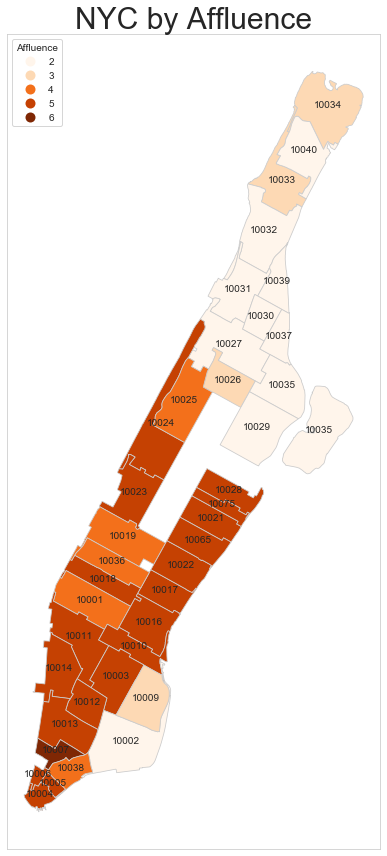

In [161]:
# set the range for the choropleth
vmin, vmax = 120, 220
# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, 1,  figsize=(20, 12))
# fig.set_facecolor((161/256, 220/256, 232/256, 0.4))
# ax.set_facecolor((161/256, 220/256, 232/256, 0.4))

merged_df.plot(column='income_buckets', 
               cmap=plt.cm.get_cmap("Oranges",6),
        linewidth=0.8,
        ax=ax,
        edgecolor='0.8',
        legend = True, legend_kwds = {'title':'Affluence', 'loc':'upper left'},
        categorical = True) ## add legend to plot

ax.set_yticks([],[]);
ax.set_xticks([],[]);
ax.set_title('NYC by Affluence', size=30);
# Creating annoations (zip codes number) to apply in our map
merged_df.apply(lambda x: ax.annotate(s=x.ZIPCODE, 
                               xy=x.geometry.centroid.coords[0], 
                               ha='center'), axis=1);
plt.tight_layout()

# Conclusion

Yelp cost estimates can determine a neighborhood’s affluence. It isn’t perfect as there may be other underlying factors that can affect affluence more than the Yelp cost estimates of restaurants. Since our model quite accurately predicts affluence of neighborhoods based on public and easily accessible data, we can allocate resources based on affluency during emergencies; primarily focusing on less affluent neighborhoods.

# Exploring Types of Businesses and Restaurant Categories

## Load in Data for Cuisine

The restaurant dataset that we created from Yelp aliases is not very helpful because there are nearly 250 categories within restaurants. We started manually condensing them by grouping them into roughly 50 cuisines, 73 overall including non-restaurants, in a separate CSV file named "restaurants_modified". 

In [162]:
manual_categories = pd.read_csv('../data/webscraped_yelp_modified.csv')

In [163]:
manual_categories = manual_categories[['cuisine', 'zipcode']]

In [164]:
manual_categories.head()

,cuisine,zipcode
0,bakery,10023.0
1,halal,10019.0
2,ramen,10003.0
3,delis,10003.0
4,museum,10028.0


In [165]:
manual_categories.shape

(4807, 2)

## Data Cleaning for Cuisine

In [166]:
# removing duplicates. Instead of count of businesses, we are assessing whether having a particular type of restaurant
# in a zip code can help us accurately categorize an affluence bucket. 
manual_categories.drop_duplicates(inplace = True)
manual_categories.shape

(1771, 2)

In [167]:
# creating a column for each cuisine type
manual_categories = pd.get_dummies(manual_categories, columns = ['cuisine'])
manual_categories.head()

,zipcode,cuisine_Bar,cuisine_Chinese,cuisine_Coffee shop,cuisine_Japanese,cuisine_South American,cuisine_Southeast Asian,cuisine_adventure,cuisine_african,cuisine_american,...,cuisine_spanish,cuisine_steak,cuisine_sushi,cuisine_tapas,cuisine_tea shop,cuisine_thai,cuisine_vegan_vegetarian,cuisine_venue,cuisine_vietnamese,cuisine_zoo
0,10023.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,10019.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10003.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,10003.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,10028.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [168]:
# consolidating the dataframe for each zip code
manual_categories = manual_categories.groupby(by = 'zipcode', as_index = False).sum()
# check the shape
manual_categories.shape

(113, 78)

In [169]:
# check what this looks like
manual_categories.head()

,zipcode,cuisine_Bar,cuisine_Chinese,cuisine_Coffee shop,cuisine_Japanese,cuisine_South American,cuisine_Southeast Asian,cuisine_adventure,cuisine_african,cuisine_american,...,cuisine_spanish,cuisine_steak,cuisine_sushi,cuisine_tapas,cuisine_tea shop,cuisine_thai,cuisine_vegan_vegetarian,cuisine_venue,cuisine_vietnamese,cuisine_zoo
0,7010.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7020.0,0,0,1,0,1,0,0,0,1,...,0,1,0,0,0,0,0,0,1,0
2,7024.0,0,0,1,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0
3,7047.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7208.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [170]:
# checking yelp dataframe
yelp.head()

,zipcode,price_$,price_$$,price_$$$,price_$$$$,median_income,avg_price
0,10001,17,59,9,1,88526.0,1.930233
1,10002,45,103,14,1,35859.0,1.822086
2,10003,32,135,27,7,112131.0,2.044776
3,10004,19,39,5,2,157645.0,1.846154
4,10005,15,21,2,1,173333.0,1.717949


In [171]:
# checking data types on Yelp dataframe
yelp.dtypes

zipcode            int64
price_$            int64
price_$$           int64
price_$$$          int64
price_$$$$         int64
median_income    float64
avg_price        float64
dtype: object

In [172]:
# checking data types on Manual Categories dataframe. The Zip code needs to be changed. 
manual_categories.dtypes

zipcode                     float64
cuisine_Bar                   uint8
cuisine_Chinese               uint8
cuisine_Coffee shop           uint8
cuisine_Japanese              uint8
                             ...   
cuisine_thai                  uint8
cuisine_vegan_vegetarian      uint8
cuisine_venue                 uint8
cuisine_vietnamese            uint8
cuisine_zoo                   uint8
Length: 78, dtype: object

In [173]:
# converting zip code in manual categories to integer, to match the yelp dataframe
manual_categories['zipcode'] = manual_categories['zipcode'].astype('int')

# Checking the changes
manual_categories.dtypes

zipcode                     int32
cuisine_Bar                 uint8
cuisine_Chinese             uint8
cuisine_Coffee shop         uint8
cuisine_Japanese            uint8
                            ...  
cuisine_thai                uint8
cuisine_vegan_vegetarian    uint8
cuisine_venue               uint8
cuisine_vietnamese          uint8
cuisine_zoo                 uint8
Length: 78, dtype: object

In [174]:
# Merge price data frame with income dataframe
df_big = pd.merge(yelp, manual_categories, how = 'left', on= 'zipcode')

df_big.head()

,zipcode,price_$,price_$$,price_$$$,price_$$$$,median_income,avg_price,cuisine_Bar,cuisine_Chinese,cuisine_Coffee shop,...,cuisine_spanish,cuisine_steak,cuisine_sushi,cuisine_tapas,cuisine_tea shop,cuisine_thai,cuisine_vegan_vegetarian,cuisine_venue,cuisine_vietnamese,cuisine_zoo
0,10001,17,59,9,1,88526.0,1.930233,1,0,1,...,0,1,1,0,0,0,1,0,0,0
1,10002,45,103,14,1,35859.0,1.822086,1,0,1,...,0,1,1,1,1,1,1,1,1,0
2,10003,32,135,27,7,112131.0,2.044776,1,1,1,...,1,1,1,1,1,1,1,0,1,0
3,10004,19,39,5,2,157645.0,1.846154,1,0,1,...,0,1,0,0,1,0,0,0,1,0
4,10005,15,21,2,1,173333.0,1.717949,1,0,1,...,0,0,1,0,0,0,0,0,0,0


In [175]:
# Assign affluence number based on median income 
buckets = []
for income in df_big['median_income']: 
    if income <= 21_300: 
        buckets.append(1)
    elif 21_300 < income <= 54_400: 
        buckets.append(2)
    elif 54_400 < income <= 75_500: 
        buckets.append(3)
    elif 75_500 < income <= 101_000:
        buckets.append(4)
    elif 101_000 < income <= 190_000: 
        buckets.append(5)
    elif 190_000 < income <= 250_000: 
        buckets.append(6)
    else: 
        buckets.append(0)

df_big['income_buckets'] = buckets

In [176]:
# identifying the zip code without median income
df_big.isnull().sum().sort_values(ascending = False)

median_income               1
income_buckets              0
cuisine_club                0
cuisine_bookstore           0
cuisine_breakfast_brunch    0
                           ..
cuisine_laundromat          0
cuisine_magicians           0
cuisine_mediterranean       0
cuisine_mexican             0
zipcode                     0
Length: 85, dtype: int64

In [177]:
# removing this zip code
df_big.dropna(inplace = True)

## Cuisine Preprocessing

In [178]:
# setting our X and Y variables
X = df_big.drop(columns = ['median_income', 'income_buckets'])
y = df['income_buckets']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)

## Cuisine Modeling

We are using the same Voting classifier model we used earlier. Our baseline is still the same at roughly 50%. 

In [179]:
# Instantiate model
vote = VotingClassifier([
    ('tree', DecisionTreeClassifier()),
    ('random', RandomForestClassifier()),
    ('ada', AdaBoostClassifier()),
    ('gb', GradientBoostingClassifier())
])

# Set parameters for grid search
vote_params = {
    'random__n_estimators': [100, 125, 150],
    'ada__n_estimators': [50, 75, 100],
    'gb__n_estimators': [100, 125, 150],
    'tree__max_depth': [None, 3, 5]
}

# Instantiate 
vote_gs = GridSearchCV(vote, param_grid = vote_params, cv = 5)

# Fit
vote_gs.fit(X_train, y_train)

# Set best model to a new variable
vote_model = vote_gs.best_estimator_

# Determine best parameters
print(f'Best parameters: {vote_gs.best_params_}')
print('')

# Score model
print(f'Score on training set: {vote_model.score(X_train, y_train)}')
print(f'Score on testing set: {vote_model.score(X_test, y_test)}')

C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 4 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\16463\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters: {'ada__n_estimators': 75, 'gb__n_estimators': 100, 'random__n_estimators': 150, 'tree__max_depth': 5}

Score on training set: 1.0
Score on testing set: 0.6428571428571429


Unfortunately, this model performs poorly. Perhaps there are better ways to cut and categorize the cuisines of restaurants, or other Yelp data we can incorporate to improve the model, but we are unable to determine at this time. 